In [19]:
%load_ext autoreload
%autoreload 2

import sys
import os
import random
import pickle
from pathlib import Path
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, auc, ConfusionMatrixDisplay, accuracy_score, RocCurveDisplay, classification_report
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier # For 3-way

from nilearn.image import load_img

BASE_DIR = Path.cwd().parent
SRC_DIR = BASE_DIR / 'src'

if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))
    print(f"Added {SRC_DIR} to sys.path")
if str(BASE_DIR) not in sys.path:
     sys.path.insert(0, str(BASE_DIR))
     print(f"Added {BASE_DIR} to sys.path")

# --- Import project modules ---
# Import the refactored classes and functions
from data_loading import load_activation_maps, run_pca_on_activation
from file_utils import load_pickle, pickle_file
from modeling import CustomGridSearch, EvaluationPipeline, CrossEvaluationPipeline, MultiClassEvaluator
from stats_utils import get_permutation_pvalue

# --- Setup Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Set Seeds ---
SEED = 2025 # Choose a different seed
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
print(f"Using random seed: {SEED}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using random seed: 2025


### CONFIGURATION

In [40]:
# --- Core Project Structure ---
DATA_DIR = BASE_DIR / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
INTERIM_DATA_DIR = DATA_DIR / "interim" # For processed data like PCA outputs
PROCESSED_DATA_DIR = DATA_DIR / "processed" # Potentially for final features if needed
MODELS_DIR = BASE_DIR / "models" / "activation" # Subdir for activation models
REPORTS_DIR = BASE_DIR / "reports"
FIGURE_DIR = REPORTS_DIR / "figures" / "activation" # Subdir for activation figures

# Create output directories
INTERIM_DATA_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
FIGURE_DIR.mkdir(parents=True, exist_ok=True)

# --- Input Data Locations ---
# Path to the directory containing the subject list CSV/Excel
SUBJECT_LIST_DIR = DATA_DIR / "metadata" # Keeping original path for now
SUBJECT_LIST_FILE = SUBJECT_LIST_DIR / "gender_controlled_splits.csv"

# Base directory for raw GLM outputs
RAW_GLM_DIR = RAW_DATA_DIR # Assumes groups dirs are directly under raw/

# Contrast names for each group
CONTRAST_MAP = {
    'alcohol': 'tasteMinusWashout',
    'cannabis': 'cueCannabisMinusCueControl'
}

# --- Preprocessing Parameters ---
# Standardization flag (applied BEFORE PCA if enabled)
STANDARDIZE_BEFORE_PCA = False
# PCA Type: 'full_rank', '70%var', '90%var', or an integer for n_components
PCA_TYPE = 'full_rank' # Or '70%var' etc.
PLOT_PCA_SCREE = True

# Path to save/load the processed data dictionary (including PCA results)
PROCESSED_DATA_DICT_PKL = INTERIM_DATA_DIR / f"activation_pca_{PCA_TYPE}_data_dict.pkl"

# --- Modeling Parameters ---
# CV Folds
GRIDSEARCH_CV_FOLDS = 5
CLASSIFICATION_CV_FOLDS = 5

# SGD Hyperparameters
# Using a standard grid from previous examples
SGD_ALPHAS_GRID = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
MAX_ITER_GRIDSEARCH = 100000 # Increased iterations for potentially high-dim PCA data
MAX_ITER_TRAINING = 100000

# Random States (Use distinct states)
RANDOM_STATE_GRIDSEARCH = 1234
RANDOM_STATE_PIPELINE = 1235
RANDOM_STATE_CROSS = 1236
RANDOM_STATE_AGG = 1237
RANDOM_STATE_MULTICLASS = 1238
RANDOM_STATE_KFOlD = 1239 # For KFold inside EvaluationPipeline/CrossEvaluationPipeline

# --- 3-Way Classification ---
# Labels MUST match the order used in label assignment later
MULTICLASS_LABELS = ['HC', 'Cannabis', 'Alcohol']
ALCOHOL_CLASS_LABEL_MULTI = MULTICLASS_LABELS.index('Alcohol') # Assign label based on list index
CANNABIS_CLASS_LABEL_MULTI = MULTICLASS_LABELS.index('Cannabis')


# --- Output File Names (Specific Models/Figures) ---
# Within-Group Models
ALCOHOL_MODEL_PKL = MODELS_DIR / f"alcohol_activation_pca_{PCA_TYPE}_classifiers.pkl"
CANNABIS_MODEL_PKL = MODELS_DIR / f"cannabis_activation_pca_{PCA_TYPE}_classifiers.pkl"
# Cross-Group Models (Optional to save, specify filenames if needed)
# Aggregated Models
AGGREGATED_MODEL_PKL = MODELS_DIR / f"aggregated_activation_pca_{PCA_TYPE}_classifiers.pkl"
# 3-Way Models
THREECLASS_ONEVREST_PKL = MODELS_DIR / f"threeclass_ovr_activation_pca_{PCA_TYPE}_classifiers.pkl"
THREECLASS_ONEVONE_PKL = MODELS_DIR / f"threeclass_ovo_activation_pca_{PCA_TYPE}_classifiers.pkl"

# Figures
# Define specific figure paths if needed, e.g.:
ALC_ROC_FIG = FIGURE_DIR / f"alc_roc_activation_pca_{PCA_TYPE}.svg"
CAN_ROC_FIG = FIGURE_DIR / f"can_roc_activation_pca_{PCA_TYPE}.svg"
# ... add paths for cross, aggregated, 3-way plots/CMs ...
MULTICLASS_OVR_CM_FIG = FIGURE_DIR / f"threeclass_ovr_cm_activation_pca_{PCA_TYPE}.svg"
MULTICLASS_OVO_CM_FIG = FIGURE_DIR / f"threeclass_ovo_cm_activation_pca_{PCA_TYPE}.svg"

# --- End Configuration ---

In [41]:
# --- Verification ---
print(f"Project Base Directory: {BASE_DIR}")
print(f"Raw GLM Base Directory: {RAW_GLM_DIR}")
print(f"Reading Subject List: {SUBJECT_LIST_FILE}")
print(f"PCA Type: {PCA_TYPE}")
print(f"Standardize before PCA: {STANDARDIZE_BEFORE_PCA}")
print(f"Processed Data Dict Path: {PROCESSED_DATA_DICT_PKL}")
print(f"Saving Models to: {MODELS_DIR}")
print(f"Saving Figures to: {FIGURE_DIR}")

if not SUBJECT_LIST_FILE.is_file():
     logging.error(f"Subject list file NOT FOUND: {SUBJECT_LIST_FILE}")
     raise FileNotFoundError(f"Subject list file not found: {SUBJECT_LIST_FILE}")
if not RAW_GLM_DIR.is_dir():
     logging.warning(f"Raw GLM directory NOT FOUND: {RAW_GLM_DIR}")

Project Base Directory: /Users/kulkarnik/LocalProjects/multiclassifier_repo
Raw GLM Base Directory: /Users/kulkarnik/LocalProjects/multiclassifier_repo/data/raw
Reading Subject List: /Users/kulkarnik/LocalProjects/multiclassifier_repo/data/metadata/gender_controlled_splits.csv
PCA Type: full_rank
Standardize before PCA: False
Processed Data Dict Path: /Users/kulkarnik/LocalProjects/multiclassifier_repo/data/interim/activation_pca_full_rank_data_dict.pkl
Saving Models to: /Users/kulkarnik/LocalProjects/multiclassifier_repo/models/activation
Saving Figures to: /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/activation


In [42]:
# === 2. Load, Preprocess (Standardize/PCA), and Cache Activation Data ===

print("\n" + "="*40)
print("Loading and Preprocessing Activation Data")
print("="*40 + "\n")

# --- Check if processed data exists ---
if PROCESSED_DATA_DICT_PKL.exists():
    print(f"Loading cached processed data from: {PROCESSED_DATA_DICT_PKL}")
    try:
        data_dict = load_pickle(PROCESSED_DATA_DICT_PKL)
        print("Successfully loaded cached data.")
        # Basic check if structure looks right
        if 'alcohol' not in data_dict or 'reduced_img_matrix' not in data_dict['alcohol']:
             print("Warning: Loaded data dict seems incomplete. Regenerating.")
             data_dict = None # Force regeneration
        else:
             print(f"  Alcohol reduced matrix shape: {data_dict['alcohol']['reduced_img_matrix'].shape}")
    except Exception as e:
        logging.error(f"Failed to load cached data: {e}. Regenerating.")
        data_dict = None
else:
    print(f"Processed data cache not found at {PROCESSED_DATA_DICT_PKL}. Generating data...")
    data_dict = None

# --- Generate data if not loaded ---
if data_dict is None:
    data_dict = {} # Initialize empty dict

    # --- Load Subject List ---
    print(f"Loading subject list from: {SUBJECT_LIST_FILE}")
    try:
        if SUBJECT_LIST_FILE.suffix == ".xlsx":
            tt_df = pd.read_excel(SUBJECT_LIST_FILE)
        elif SUBJECT_LIST_FILE.suffix == ".csv":
            tt_df = pd.read_csv(SUBJECT_LIST_FILE)
        else:
            raise ValueError(f"Unsupported file format: {SUBJECT_LIST_FILE.suffix}")
        print(f"Loaded {len(tt_df)} subjects/entries.")
    except Exception as e:
        raise RuntimeError(f"Failed to load subject list {SUBJECT_LIST_FILE}: {e}")

    # --- Load Raw Activation Maps ---
    raw_data = {}
    groups_to_load = ['alcohol', 'cannabis'] # Based on CONTRAST_MAP keys
    for group in groups_to_load:
        contrast = CONTRAST_MAP.get(group)
        if not contrast:
             logging.warning(f"No contrast defined for group '{group}' in CONTRAST_MAP. Skipping.")
             continue

        img_matrix, labels, run_ids, sub_names, training_flags, missing = load_activation_maps(
            subjects_df=tt_df,
            group_name=group,
            base_data_dir=RAW_GLM_DIR,
            contrast_name=contrast
        )
        if img_matrix is not None:
             raw_data[group] = {
                 'img_matrix': img_matrix, # Raw flattened data
                 'labels': labels,
                 'run_ids': run_ids,
                 'sub_names': sub_names,
                 'training': training_flags, # Boolean mask
                 'missing_subs': missing
             }
        else:
            logging.error(f"Failed to load any data for group '{group}'. Check paths and contrast names.")
            # Decide how to handle - skip group or raise error? Let's skip.


    # --- Run PCA (Per Group) ---
    # Note: This runs PCA separately for each group's raw activation data.
    # Aggregated analysis later might need PCA on combined data instead.
    print("\nRunning PCA per group...")
    processed_data = {}
    for group, group_data in raw_data.items():
        print(f"  Running PCA for group: {group}")
        reduced_matrix_df = run_pca_on_activation(
            img_matrix=group_data['img_matrix'],
            pca_type=PCA_TYPE,
            plot_scree=PLOT_PCA_SCREE,
            standardize_before_pca=STANDARDIZE_BEFORE_PCA
        )
        if reduced_matrix_df is not None:
             # Store reduced matrix and copy other metadata
             processed_data[group] = {
                 'reduced_img_matrix': reduced_matrix_df, # Store as DataFrame
                 'labels': group_data['labels'],
                 'run_ids': group_data['run_ids'],
                 'sub_names': group_data['sub_names'],
                 'training': group_data['training'],
                 'missing_subs': group_data['missing_subs'],
                 'img_matrix': group_data['img_matrix'] # Keep raw data if needed later? Optional.
             }
        else:
            logging.error(f"PCA failed for group '{group}'. This group will be excluded from the data dictionary.")

    data_dict = processed_data # Assign processed data to main dict

    # --- Save Processed Data ---
    if data_dict: # Only save if processing was successful for at least one group
        print(f"\nCaching processed data to: {PROCESSED_DATA_DICT_PKL}")
        try:
            pickle_file(data_dict, PROCESSED_DATA_DICT_PKL) # Use utility function
        except Exception as e:
            logging.error(f"Failed to save processed data cache: {e}")
    else:
         logging.error("No data was successfully processed. data_dict is empty.")


# --- Final Verification ---
print("\nFinal structure of loaded/processed data_dict:")
for group, content in data_dict.items():
    print(f"  Group: {group}")
    for key, value in content.items():
        if isinstance(value, (np.ndarray, pd.DataFrame)):
             print(f"    {key}: shape={value.shape}")
        elif isinstance(value, list):
             print(f"    {key}: length={len(value)}")
        # else: print(f"    {key}: type={type(value)}") # Less useful usually

print("\n" + "="*40)
print("Finished Loading and Preprocessing Activation Data")
print("="*40 + "\n")


Loading and Preprocessing Activation Data

Loading cached processed data from: /Users/kulkarnik/LocalProjects/multiclassifier_repo/data/interim/activation_pca_full_rank_data_dict.pkl


2025-04-21 16:00:25,167 - INFO - Successfully loaded data from /Users/kulkarnik/LocalProjects/multiclassifier_repo/data/interim/activation_pca_full_rank_data_dict.pkl


Successfully loaded cached data.
  Alcohol reduced matrix shape: (281, 889)

Final structure of loaded/processed data_dict:
  Group: alcohol
    img_matrix: shape=(281, 1082035)
    reduced_img_matrix: shape=(281, 889)
    labels: shape=(281,)
    run_ids: shape=(281,)
    sub_names: shape=(281,)
    training: shape=(281,)
    missing_subs: shape=(133,)
  Group: cannabis
    img_matrix: shape=(608, 1082035)
    reduced_img_matrix: shape=(608, 889)
    labels: shape=(608,)
    run_ids: shape=(608,)
    sub_names: shape=(608,)
    training: shape=(608,)
    missing_subs: shape=(24,)
  Group: agg_reduced_img_matrix

Finished Loading and Preprocessing Activation Data




Visualizing input data matrices (after PCA)...
  Max absolute value for unscaled colormap: 607.50


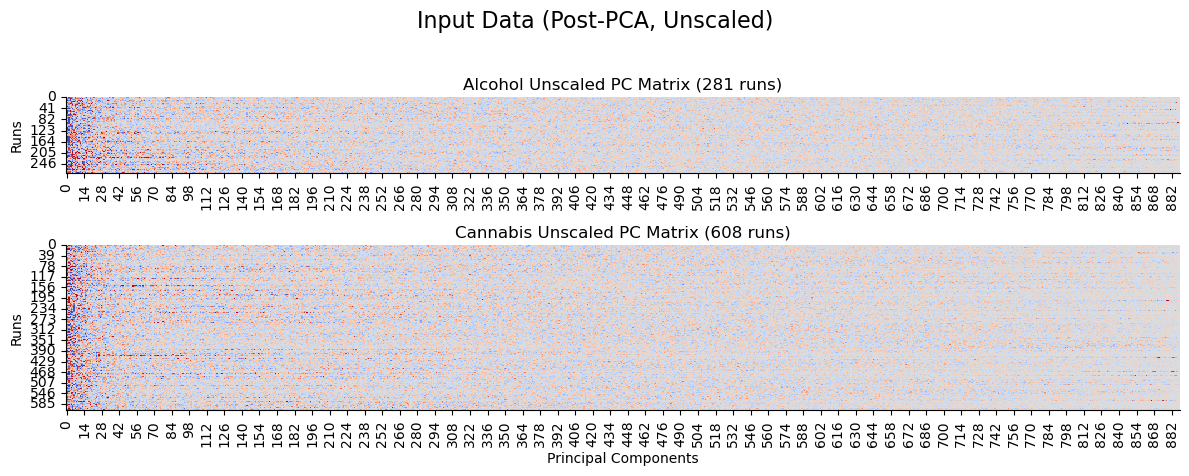

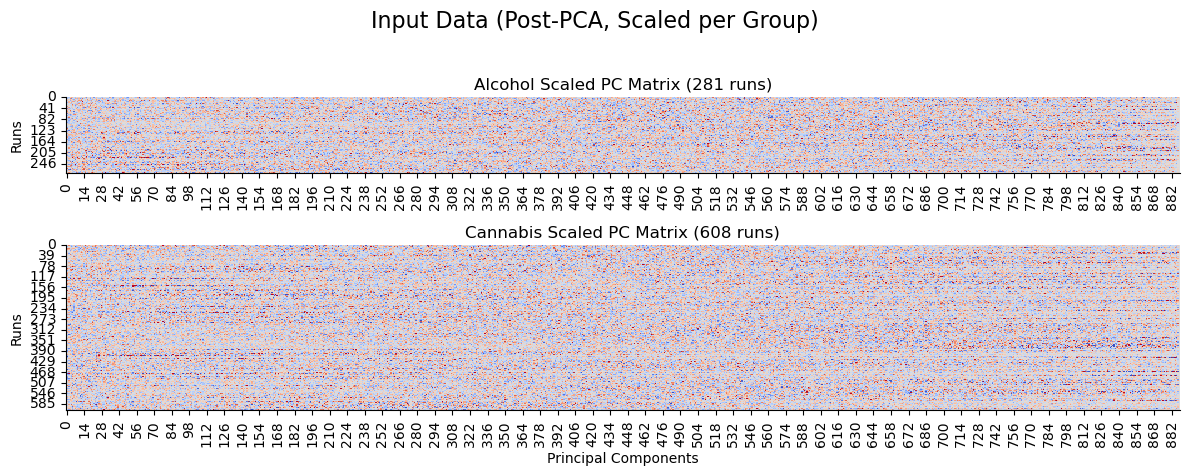

In [43]:
# === 3a. Visualize Processed Data (Heatmaps) ===
print("\nVisualizing input data matrices (after PCA)...")

groups_to_plot = ['alcohol', 'cannabis'] #list(data_dict.keys())
n_groups_plot = len(groups_to_plot)

if n_groups_plot > 0:
    # Determine height ratios based on number of runs per group
    height_ratios = [data_dict[group]['reduced_img_matrix'].shape[0] for group in groups_to_plot]

    # --- Plot Unscaled Data ---
    fig_unscaled, axes_unscaled = plt.subplots(
        nrows=n_groups_plot, ncols=1, figsize=(12, 2 + sum(height_ratios)*0.003), # Adjust size dynamically
        gridspec_kw={'height_ratios': height_ratios}
    )
    if n_groups_plot == 1: axes_unscaled = [axes_unscaled] # Make iterable if only one group

    fig_unscaled.suptitle("Input Data (Post-PCA, Unscaled)", fontsize=16, y=1.01)
    max_abs_val = 0 # Find max absolute value across groups for consistent cmap
    for group in groups_to_plot:
        mat = data_dict[group]['reduced_img_matrix'].values # Use numpy array
        max_abs_val = max(max_abs_val, np.max(np.abs(mat)))

    print(f"  Max absolute value for unscaled colormap: {max_abs_val:.2f}")
    vlim = max(50, min(max_abs_val, 100)) # Set reasonable vlim limits

    for i, group in enumerate(groups_to_plot):
        matrix_to_plot = data_dict[group]['reduced_img_matrix'].values
        sns.heatmap(matrix_to_plot, ax=axes_unscaled[i], cbar=False, cmap='coolwarm', center=0, vmin=-vlim, vmax=vlim)
        axes_unscaled[i].set_title(f"{group.capitalize()} Unscaled PC Matrix ({matrix_to_plot.shape[0]} runs)")
        axes_unscaled[i].set_ylabel("Runs")
        if i == n_groups_plot - 1: axes_unscaled[i].set_xlabel("Principal Components")

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    sns.despine()
    plt.show()

    # --- Plot Scaled Data ---
    # Note: Scaling is done independently per group here just for visualization
    fig_scaled, axes_scaled = plt.subplots(
        nrows=n_groups_plot, ncols=1, figsize=(12, 2 + sum(height_ratios)*0.003),
        gridspec_kw={'height_ratios': height_ratios}
    )
    if n_groups_plot == 1: axes_scaled = [axes_scaled]

    fig_scaled.suptitle("Input Data (Post-PCA, Scaled per Group)", fontsize=16, y=1.01)
    vlim_scaled = 3.0 # Typical range for scaled data

    for i, group in enumerate(groups_to_plot):
        try:
             scaler_viz = StandardScaler()
             matrix_to_plot_scaled = scaler_viz.fit_transform(data_dict[group]['reduced_img_matrix'].values)
             sns.heatmap(matrix_to_plot_scaled, ax=axes_scaled[i], cbar=False, cmap='coolwarm', vmin=-vlim_scaled, vmax=vlim_scaled)
             axes_scaled[i].set_title(f"{group.capitalize()} Scaled PC Matrix ({matrix_to_plot_scaled.shape[0]} runs)")
             axes_scaled[i].set_ylabel("Runs")
             if i == n_groups_plot - 1: axes_scaled[i].set_xlabel("Principal Components")
        except Exception as e:
             axes_scaled[i].set_title(f"{group.capitalize()} - Scaling Error")
             logging.error(f"Error scaling/plotting group {group}: {e}")


    plt.tight_layout(rect=[0, 0, 1, 0.98])
    sns.despine()
    plt.show()

else:
    print("No data available in data_dict to visualize.")


Visualizing distributions of input data values (after PCA)...


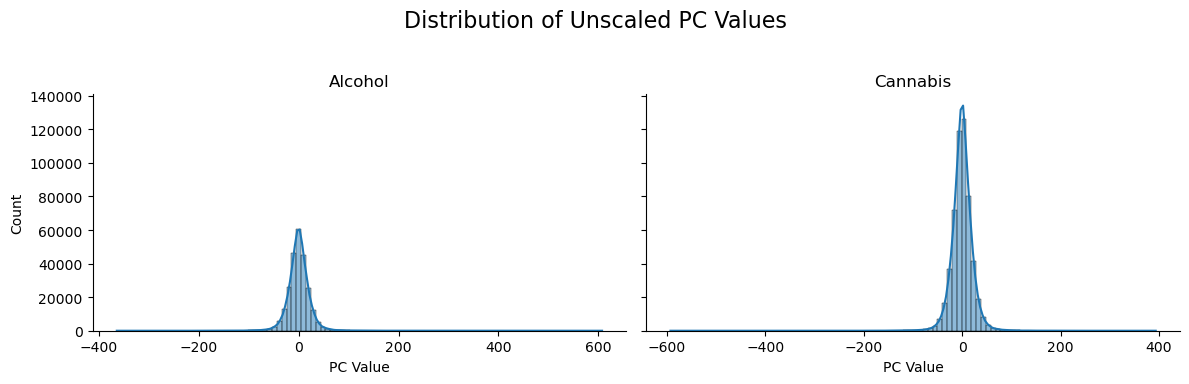

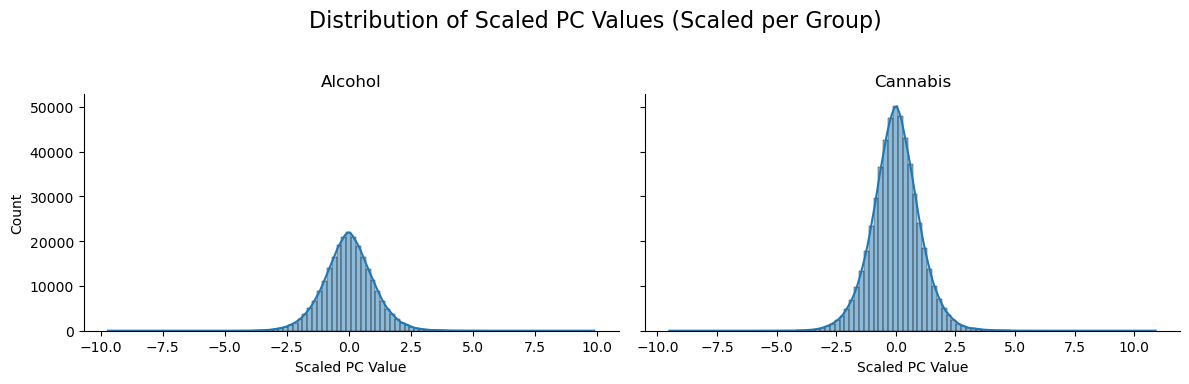

In [44]:
# === 3b. Visualize Processed Data (Histograms) ===
print("\nVisualizing distributions of input data values (after PCA)...")

groups_to_plot = ['alcohol', 'cannabis'] #list(data_dict.keys())
n_groups_plot = len(groups_to_plot)

if n_groups_plot > 0:
    # --- Plot Unscaled Histograms ---
    fig_hist_unscaled, axes_hist_unscaled = plt.subplots(1, n_groups_plot, figsize=(6*n_groups_plot, 4), sharey=True)
    if n_groups_plot == 1: axes_hist_unscaled = [axes_hist_unscaled]
    fig_hist_unscaled.suptitle("Distribution of Unscaled PC Values", fontsize=16)

    for i, group in enumerate(groups_to_plot):
        try:
            data_flat = data_dict[group]['reduced_img_matrix'].values.flatten()
            sns.histplot(data_flat, bins=100, ax=axes_hist_unscaled[i], kde=True)
            axes_hist_unscaled[i].set_title(group.capitalize())
            axes_hist_unscaled[i].set_xlabel("PC Value")
            if i > 0: axes_hist_unscaled[i].set_ylabel("") # Remove redundant y label
        except Exception as e:
            axes_hist_unscaled[i].set_title(f"{group.capitalize()} - Error")
            logging.error(f"Error plotting unscaled histogram for {group}: {e}")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    sns.despine()
    plt.show()

    # --- Plot Scaled Histograms ---
    fig_hist_scaled, axes_hist_scaled = plt.subplots(1, n_groups_plot, figsize=(6*n_groups_plot, 4), sharey=True)
    if n_groups_plot == 1: axes_hist_scaled = [axes_hist_scaled]
    fig_hist_scaled.suptitle("Distribution of Scaled PC Values (Scaled per Group)", fontsize=16)

    for i, group in enumerate(groups_to_plot):
        try:
            scaler_viz = StandardScaler()
            data_scaled_flat = scaler_viz.fit_transform(data_dict[group]['reduced_img_matrix'].values).flatten()
            sns.histplot(data_scaled_flat, bins=100, ax=axes_hist_scaled[i], kde=True)
            axes_hist_scaled[i].set_title(group.capitalize())
            axes_hist_scaled[i].set_xlabel("Scaled PC Value")
            if i > 0: axes_hist_scaled[i].set_ylabel("")
        except Exception as e:
            axes_hist_scaled[i].set_title(f"{group.capitalize()} - Error")
            logging.error(f"Error plotting scaled histogram for {group}: {e}")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    sns.despine()
    plt.show()

else:
    print("No data available in data_dict to visualize histograms.")

In [45]:
# === 4. Helper Functions for Train/Test Splitting ===
# These functions extract train/test sets from the data_dict based on the 'training' boolean mask.
# Note: They do NOT apply scaling here; scaling should happen just before classification if desired.

def get_train_X(group_data_dict: dict, data_key: str = 'reduced_img_matrix') -> np.ndarray:
    """Gets training features (e.g., PCA components)."""
    if data_key not in group_data_dict or 'training' not in group_data_dict:
        logging.error(f"Missing '{data_key}' or 'training' in group_data_dict.")
        return np.array([])
    return group_data_dict[data_key].values[group_data_dict['training'].astype(bool)] # Use boolean mask

def get_test_X(group_data_dict: dict, data_key: str = 'reduced_img_matrix') -> np.ndarray:
    """Gets testing features (e.g., PCA components)."""
    if data_key not in group_data_dict or 'training' not in group_data_dict:
        logging.error(f"Missing '{data_key}' or 'training' in group_data_dict.")
        return np.array([])
    return group_data_dict[data_key].values[~group_data_dict['training'].astype(bool)] # Invert mask

def get_train_y(group_data_dict: dict) -> np.ndarray:
    """Gets training labels."""
    if 'labels' not in group_data_dict or 'training' not in group_data_dict:
        logging.error("Missing 'labels' or 'training' in group_data_dict.")
        return np.array([])
    return group_data_dict['labels'][group_data_dict['training'].astype(bool)]

def get_test_y(group_data_dict: dict) -> np.ndarray:
    """Gets testing labels."""
    if 'labels' not in group_data_dict or 'training' not in group_data_dict:
        logging.error("Missing 'labels' or 'training' in group_data_dict.")
        return np.array([])
    return group_data_dict['labels'][~group_data_dict['training'].astype(bool)]

def get_train_ids(group_data_dict: dict) -> np.ndarray:
    """Gets training subject IDs."""
    if 'sub_names' not in group_data_dict or 'training' not in group_data_dict:
        logging.error("Missing 'sub_names' or 'training' in group_data_dict.")
        return np.array([])
    return group_data_dict['sub_names'][group_data_dict['training'].astype(bool)]

def get_test_ids(group_data_dict: dict) -> np.ndarray:
    """Gets testing subject IDs."""
    if 'sub_names' not in group_data_dict or 'training' not in group_data_dict:
        logging.error("Missing 'sub_names' or 'training' in group_data_dict.")
        return np.array([])
    return group_data_dict['sub_names'][~group_data_dict['training'].astype(bool)]

print("Helper functions for train/test splitting defined.")

Helper functions for train/test splitting defined.


In [46]:
# === 5. Alcohol: Grid Search ===

print("\n" + "="*40)
print("Starting Alcohol Activation Classification - Grid Search")
print("="*40 + "\n")

# --- Get Data ---
print("Extracting Alcohol training data...")
try:
    # Get the PCA-reduced data (DataFrame)
    alc_X_train_df = data_dict['alcohol']['reduced_img_matrix']
    alc_training_mask = data_dict['alcohol']['training']
    alc_labels = data_dict['alcohol']['labels']

    # Apply training mask and convert DataFrame to numpy array
    alc_X_train = alc_X_train_df.values[alc_training_mask.astype(bool)]
    alc_y_train = alc_labels[alc_training_mask.astype(bool)]

    if alc_X_train.size == 0 or alc_y_train.size == 0:
         raise ValueError("Alcohol training data is empty after masking.")
    print(f"  Alcohol Training Data Shape: X={alc_X_train.shape}, y={alc_y_train.shape}")
except KeyError:
    raise KeyError("Data for 'alcohol' group (or required keys like 'reduced_img_matrix', 'training', 'labels') not found in data_dict.")
except Exception as e:
    raise RuntimeError(f"Error preparing alcohol training data: {e}")

# --- Grid Search Setup ---
param_grid_sgd_pipeline = {
    'estimator__loss': ['hinge', 'log_loss'],
    'estimator__penalty': ['l2', 'l1'],
    'estimator__alpha': SGD_ALPHAS_GRID # Use alpha grid from config
}

# Instantiate and run search
gs_runner_alc = CustomGridSearch(
    param_grid=param_grid_sgd_pipeline,
    random_state=RANDOM_STATE_GRIDSEARCH,
    max_iter=MAX_ITER_GRIDSEARCH
)
print(f"\nRunning GridSearchCV on Alcohol Activation Data...")
# NOTE: We are running grid search on the potentially unscaled PCA output.
# Scaling is implicitly handled by GridSearchCV's internal CV if not using a Pipeline.
# If consistent scaling is critical *during* search, use Pipeline(StandardScaler(), SGDClassifier()).
gs_runner_alc.run_search(
    alc_X_train, # Pass unscaled PCA data
    alc_y_train,
    cv=GRIDSEARCH_CV_FOLDS,
    scoring='accuracy', # Or 'roc_auc'
    n_jobs=-1,
    verbose=1
)

# --- Extract Best Alphas ---
alc_best_alphas = gs_runner_alc.get_best_alphas()
print("\nBest Alphas Found (Alcohol):")
if alc_best_alphas:
    # Create a DataFrame for nice display
    alphas_df_alc = pd.DataFrame(alc_best_alphas, index=['best_alpha']).T
    alphas_df_alc.index.name = 'Loss_Penalty'
    display(alphas_df_alc)
else:
    print("  No best alphas extracted (grid search may have failed). Using defaults.")
    # Define fallbacks if needed downstream
    alc_best_alphas = {
        'log_loss_l1': 1e-4, 'log_loss_l2': 1e-4,
        'hinge_l1': 1e-4, 'hinge_l2': 1e-4
    } # Example defaults

# Optional: Display full results DataFrame
# alc_gs_results_df = gs_runner_alc.get_results_df()
# if alc_gs_results_df is not None:
#     print("\nFull Grid Search Results (Alcohol):")
#     display(alc_gs_results_df)


print("\n" + "="*40)
print("Finished Alcohol Grid Search")
print("="*40 + "\n")

2025-04-21 16:00:28,983 - INFO - Running GridSearchCV for Pipeline(StandardScaler, SGDClassifier)...



Starting Alcohol Activation Classification - Grid Search

Extracting Alcohol training data...
  Alcohol Training Data Shape: X=(222, 889), y=(222,)

Running GridSearchCV on Alcohol Activation Data...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


2025-04-21 16:00:29,551 - INFO - GridSearchCV finished in 0.57 seconds.
2025-04-21 16:00:29,552 - INFO - Best overall pipeline score: 0.5181
2025-04-21 16:00:29,552 - INFO - Best overall pipeline params: {'estimator__alpha': 0.1, 'estimator__loss': 'hinge', 'estimator__penalty': 'l1'}
2025-04-21 16:00:29,555 - INFO - Best alpha for hinge_l2: 0.00010 (score: 0.5000)
2025-04-21 16:00:29,556 - INFO - Best alpha for hinge_l1: 0.10000 (score: 0.5181)
2025-04-21 16:00:29,556 - INFO - Best alpha for log_loss_l2: 1.00000 (score: 0.5044)
2025-04-21 16:00:29,557 - INFO - Best alpha for log_loss_l1: 0.00100 (score: 0.5000)



Best Alphas Found (Alcohol):


,best_alpha
Loss_Penalty,
hinge_l2,0.0001
hinge_l1,0.1000
log_loss_l2,1.0000
log_loss_l1,0.0010



Finished Alcohol Grid Search



2025-04-21 16:00:29,601 - INFO - Running 5-fold CV for L1_logistic (with scaling)...
2025-04-21 16:00:29,638 - INFO -   L1_logistic: Mean CV Accuracy = 0.4581 +/- 0.0730
2025-04-21 16:00:29,638 - INFO -   L1_logistic: Total Confusion Matrix (across folds):
[[66. 46.]
 [74. 36.]]
2025-04-21 16:00:29,647 - INFO -   Fitted final pipeline for L1_logistic on full training data.
2025-04-21 16:00:29,647 - INFO - Running 5-fold CV for L2_logistic (with scaling)...
2025-04-21 16:00:29,677 - INFO -   L2_logistic: Mean CV Accuracy = 0.4426 +/- 0.0677
2025-04-21 16:00:29,677 - INFO -   L2_logistic: Total Confusion Matrix (across folds):
[[51. 61.]
 [63. 47.]]
2025-04-21 16:00:29,685 - INFO -   Fitted final pipeline for L2_logistic on full training data.
2025-04-21 16:00:29,686 - INFO - Running 5-fold CV for L1_LinearSVC (with scaling)...



Starting Alcohol Activation Classification - Evaluation (with Pipeline)

Extracting Alcohol train/test data...
  Train Shapes (Unscaled): X=(222, 889), y=(222,), ids=(222,)
  Test Shapes (Unscaled): X=(59, 889), y=(59,)

Defining BASE classifiers using best alphas from grid search...
  Defined BASE L1_logistic with alpha=0.001000
  Defined BASE L2_logistic with alpha=1.000000
  Defined BASE L1_LinearSVC with alpha=0.100000
  Defined BASE L2_LinearSVC with alpha=0.000100

Running evaluation pipeline (includes internal scaling)...


2025-04-21 16:00:30,022 - INFO -   L1_LinearSVC: Mean CV Accuracy = 0.4690 +/- 0.0194
2025-04-21 16:00:30,023 - INFO -   L1_LinearSVC: Total Confusion Matrix (across folds):
[[52. 60.]
 [58. 52.]]
2025-04-21 16:00:30,145 - INFO -   Fitted final pipeline for L1_LinearSVC on full training data.
2025-04-21 16:00:30,145 - INFO - Running 5-fold CV for L2_LinearSVC (with scaling)...
2025-04-21 16:00:30,172 - INFO -   L2_LinearSVC: Mean CV Accuracy = 0.4626 +/- 0.0727
2025-04-21 16:00:30,173 - INFO -   L2_LinearSVC: Total Confusion Matrix (across folds):
[[67. 45.]
 [74. 36.]]
2025-04-21 16:00:30,179 - INFO -   Fitted final pipeline for L2_LinearSVC on full training data.



Saved Alcohol ROC curve figure to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/activation/alc_roc_activation_pca_full_rank.svg

Alcohol Cross-Validation Metrics Summary:


,Estimator,Mean CV Accuracy,Std CV Accuracy,Mean CV AUC,Std CV AUC,Total TP,Total FP,Total FN,Total TN,Overall Precision,Overall Recall (Sensitivity),Overall Specificity,Overall F1-Score
0,L1_logistic,0.4581,0.0730,0.4934,0.0586,36.0,46.0,74.0,66.0,0.4390,0.3273,0.5893,0.3750
1,L2_logistic,0.4426,0.0677,0.4876,0.0502,47.0,61.0,63.0,51.0,0.4352,0.4273,0.4554,0.4312
2,L1_LinearSVC,0.4690,0.0194,0.4575,0.0502,52.0,60.0,58.0,52.0,0.4643,0.4727,0.4643,0.4685
3,L2_LinearSVC,0.4626,0.0727,0.4807,0.0541,36.0,45.0,74.0,67.0,0.4444,0.3273,0.5982,0.3770


2025-04-21 16:00:30,500 - INFO - Saved final fitted pipelines to /Users/kulkarnik/LocalProjects/multiclassifier_repo/models/activation/alcohol_activation_pca_full_rank_classifiers.pkl
2025-04-21 16:00:30,501 - INFO - Successfully loaded data from /Users/kulkarnik/LocalProjects/multiclassifier_repo/models/activation/alcohol_activation_pca_full_rank_classifiers.pkl



--- Alcohol Hold-Out Test Set Evaluation (using saved Pipelines) ---
Loaded 4 pipelines for evaluation.

Model: L1_logistic
  Test Accuracy: 0.4915
  Test Confusion Matrix:
[[29  0]
 [30  0]]

Model: L2_logistic
  Test Accuracy: 0.5085
  Test Confusion Matrix:
[[29  0]
 [29  1]]

Model: L1_LinearSVC
  Test Accuracy: 0.4746
  Test Confusion Matrix:
[[20  9]
 [22  8]]

Model: L2_LinearSVC
  Test Accuracy: 0.4915
  Test Confusion Matrix:
[[29  0]
 [30  0]]

Finished Alcohol Evaluation (with Pipeline)



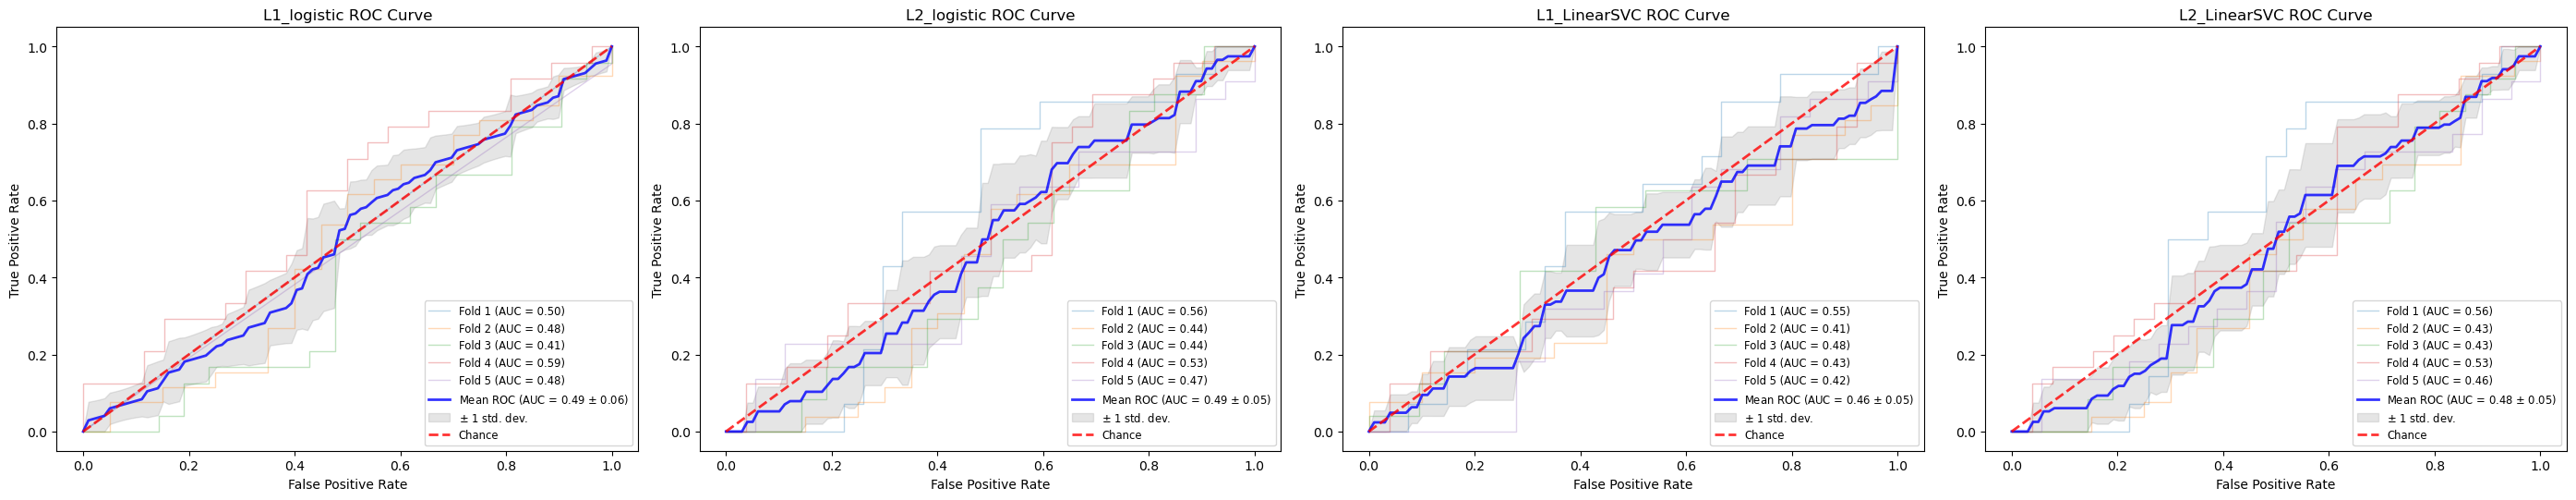

In [47]:
# === 6. Alcohol: Evaluation (Using Pipeline) ===

print("\n" + "="*40)
print("Starting Alcohol Activation Classification - Evaluation (with Pipeline)")
print("="*40 + "\n")

# --- Get Data (No Scaling Here) ---
# Extract unscaled PCA data and labels/IDs using helper functions
print("Extracting Alcohol train/test data...")
try:
    alc_X_train = get_train_X(data_dict['alcohol']) # Gets numpy array
    alc_y_train = get_train_y(data_dict['alcohol'])
    alc_X_test = get_test_X(data_dict['alcohol'])
    alc_y_test = get_test_y(data_dict['alcohol'])
    alc_train_ids = get_train_ids(data_dict['alcohol']) # For subject-based CV
    if alc_X_train.size==0 or alc_y_train.size==0 or alc_X_test.size==0 or alc_y_test.size==0 or alc_train_ids.size==0:
         raise ValueError("Alcohol train/test/id data is empty or incomplete.")
    print(f"  Train Shapes (Unscaled): X={alc_X_train.shape}, y={alc_y_train.shape}, ids={alc_train_ids.shape}")
    print(f"  Test Shapes (Unscaled): X={alc_X_test.shape}, y={alc_y_test.shape}")
except KeyError:
    raise KeyError("Data for 'alcohol' group not found in data_dict.")
except Exception as e:
    raise RuntimeError(f"Error preparing alcohol data: {e}")


# --- Define BASE Classifiers using Best Alphas ---
# Create instances of the base SGDClassifier, not the pipeline yet
print("\nDefining BASE classifiers using best alphas from grid search...")
classifiers_alc_base = {}
# Define structure for iterating variants if not already defined
sgd_variants_eval = [
    {'loss': 'log_loss', 'penalty': 'l1', 'name': 'L1_logistic'},
    {'loss': 'log_loss', 'penalty': 'l2', 'name': 'L2_logistic'},
    {'loss': 'hinge', 'penalty': 'l1', 'name': 'L1_LinearSVC'},
    {'loss': 'hinge', 'penalty': 'l2', 'name': 'L2_LinearSVC'}
]
for variant in sgd_variants_eval:
    combo_key = f"{variant['loss']}_{variant['penalty']}" # Key used in alc_best_alphas
    classifier_name = variant['name']
    # Use found alpha or default if not found in grid search results
    best_alpha = alc_best_alphas.get(combo_key, 1e-4) # Default alpha if key missing

    classifiers_alc_base[classifier_name] = SGDClassifier(
        loss=variant['loss'],
        penalty=variant['penalty'],
        alpha=best_alpha,
        random_state=RANDOM_STATE_PIPELINE, # Use pipeline-specific state
        max_iter=MAX_ITER_TRAINING,        # Use training iterations
        class_weight='balanced'
    )
    print(f"  Defined BASE {classifier_name} with alpha={best_alpha:.6f}")


# --- Run Evaluation Pipeline ---
# Pass the dictionary of BASE classifiers to the pipeline
print("\nRunning evaluation pipeline (includes internal scaling)...")
evaluator_alc = EvaluationPipeline(classifiers_alc_base) # Pass BASE classifiers

# The run_cv_and_plot method now handles scaling internally via Pipeline
# It returns fitted PIPELINES
fig_alc, axes_alc, fitted_pipelines_alc = evaluator_alc.run_cv_and_plot(
    X_train=alc_X_train, # Pass UNSCALED train data
    y_train=alc_y_train,
    train_ids=alc_train_ids,
    num_folds=CLASSIFICATION_CV_FOLDS,
    random_state_kfold=RANDOM_STATE_KFOlD
)

# --- Save ROC Figure ---
try:
    # Ensure parent directory exists
    FIGURE_DIR.mkdir(parents=True, exist_ok=True)
    fig_alc.savefig(ALC_ROC_FIG, format='svg', dpi=1200, bbox_inches='tight')
    print(f"\nSaved Alcohol ROC curve figure to {ALC_ROC_FIG}")
except Exception as e:
    logging.error(f"Error saving ROC figure {ALC_ROC_FIG}: {e}", exc_info=True)
# plt.close(fig_alc) # Close figure


# --- Display CV Metrics ---
alc_metrics_df = evaluator_alc.get_cv_metrics_summary()
print("\nAlcohol Cross-Validation Metrics Summary:")
display(alc_metrics_df) # Use display for nice notebook formatting


# --- Save Final Fitted PIPELINES ---
# The evaluator fits final pipelines on the full UNSCALED training data
evaluator_alc.save_fitted_models(ALCOHOL_MODEL_PKL) # Saves the dict of pipelines


# --- Evaluate on Hold-Out Test Set using Saved PIPELINES ---
print("\n--- Alcohol Hold-Out Test Set Evaluation (using saved Pipelines) ---")
try:
    # Load the saved dictionary of pipelines
    loaded_pipelines_alc = load_pickle(ALCOHOL_MODEL_PKL) # Use file_utils function

    if loaded_pipelines_alc and isinstance(loaded_pipelines_alc, dict):
        print(f"Loaded {len(loaded_pipelines_alc)} pipelines for evaluation.")
        for model_name, final_pipeline in loaded_pipelines_alc.items():
             # Check if it's a valid Pipeline object
             if final_pipeline and isinstance(final_pipeline, Pipeline):
                 try:
                     # Predict using the loaded PIPELINE on the UNSCALED test data
                     preds_test_alc = final_pipeline.predict(alc_X_test) # Pass unscaled test data
                     test_acc_alc = accuracy_score(alc_y_test, preds_test_alc)
                     test_cm_alc = confusion_matrix(alc_y_test, preds_test_alc)
                     print(f"\nModel: {model_name}")
                     print(f"  Test Accuracy: {test_acc_alc:.4f}")
                     print(f"  Test Confusion Matrix:\n{test_cm_alc}")
                 except Exception as e:
                      logging.error(f"\nModel: {model_name} - Error during test prediction/evaluation: {e}", exc_info=True)
             elif final_pipeline is None:
                  print(f"\nModel: {model_name} - Final model fitting failed (was None in saved file).")
             else:
                  print(f"\nModel: {model_name} - Loaded object is not a valid Pipeline (type: {type(final_pipeline).__name__}).")
    else:
        print(f"No valid pipelines loaded from {ALCOHOL_MODEL_PKL} for test evaluation.")

except FileNotFoundError:
    logging.error(f"Could not load saved pipelines from {ALCOHOL_MODEL_PKL}. File not found.")
except Exception as e:
    logging.error(f"An error occurred loading or evaluating pipelines: {e}", exc_info=True)


print("\n" + "="*40)
print("Finished Alcohol Evaluation (with Pipeline)")
print("="*40 + "\n")

In [48]:
# === 7. Cannabis: Grid Search ===

print("\n" + "="*40)
print("Starting Cannabis Activation Classification - Grid Search")
print("="*40 + "\n")

# --- Get Data ---
print("Extracting Cannabis training data...")
try:
    # Get the PCA-reduced data (DataFrame)
    can_X_train_df = data_dict['cannabis']['reduced_img_matrix']
    can_training_mask = data_dict['cannabis']['training']
    can_labels = data_dict['cannabis']['labels']

    # Apply training mask and convert DataFrame to numpy array
    can_X_train = can_X_train_df.values[can_training_mask.astype(bool)]
    can_y_train = can_labels[can_training_mask.astype(bool)]

    if can_X_train.size == 0 or can_y_train.size == 0:
         raise ValueError("Cannabis training data is empty after masking.")
    print(f"  Cannabis Training Data Shape: X={can_X_train.shape}, y={can_y_train.shape}")
except KeyError:
    raise KeyError("Data for 'cannabis' group (or required keys like 'reduced_img_matrix', 'training', 'labels') not found in data_dict.")
except Exception as e:
    raise RuntimeError(f"Error preparing Cannabis training data: {e}")

# --- Grid Search Setup ---
param_grid_sgd_pipeline = {
    'estimator__loss': ['hinge', 'log_loss'],
    'estimator__penalty': ['l2', 'l1'],
    'estimator__alpha': SGD_ALPHAS_GRID # Use alpha grid from config
}

# Instantiate and run search
gs_runner_can = CustomGridSearch(
    param_grid=param_grid_sgd_pipeline,
    random_state=RANDOM_STATE_GRIDSEARCH,
    max_iter=MAX_ITER_GRIDSEARCH
)
print(f"\nRunning GridSearchCV on Cannabis Activation Data...")
# NOTE: We are running grid search on the potentially unscaled PCA output.
# Scaling is implicitly handled by GridSearchCV's internal CV if not using a Pipeline.
# If consistent scaling is critical *during* search, use Pipeline(StandardScaler(), SGDClassifier()).
gs_runner_can.run_search(
    can_X_train, # Pass unscaled PCA data
    can_y_train,
    cv=GRIDSEARCH_CV_FOLDS,
    scoring='accuracy', # Or 'roc_auc'
    n_jobs=-1,
    verbose=1
)

# --- Extract Best Alphas ---
can_best_alphas = gs_runner_can.get_best_alphas()
print("\nBest Alphas Found (Cannabis):")
if can_best_alphas:
    # Create a DataFrame for nice display
    alphas_df_can = pd.DataFrame(can_best_alphas, index=['best_alpha']).T
    alphas_df_can.index.name = 'Loss_Penalty'
    display(alphas_df_can)
else:
    print("  No best alphas extracted (grid search may have failed). Using defaults.")
    # Define fallbacks if needed downstream
    can_best_alphas = {
        'log_loss_l1': 1e-4, 'log_loss_l2': 1e-4,
        'hinge_l1': 1e-4, 'hinge_l2': 1e-4
    } # Example defaults

# Optional: Display full results DataFrame
# can_gs_results_df = gs_runner_can.get_results_df()
# if can_gs_results_df is not None:
#     print("\nFull Grid Search Results (Cannabis):")
#     display(can_gs_results_df)


print("\n" + "="*40)
print("Finished Cannabis Grid Search")
print("="*40 + "\n")

2025-04-21 16:00:33,239 - INFO - Running GridSearchCV for Pipeline(StandardScaler, SGDClassifier)...



Starting Cannabis Activation Classification - Grid Search

Extracting Cannabis training data...
  Cannabis Training Data Shape: X=(490, 889), y=(490,)

Running GridSearchCV on Cannabis Activation Data...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


2025-04-21 16:00:33,781 - INFO - GridSearchCV finished in 0.54 seconds.
2025-04-21 16:00:33,782 - INFO - Best overall pipeline score: 0.6020
2025-04-21 16:00:33,782 - INFO - Best overall pipeline params: {'estimator__alpha': 1.0, 'estimator__loss': 'hinge', 'estimator__penalty': 'l2'}
2025-04-21 16:00:33,783 - INFO - Best alpha for hinge_l2: 1.00000 (score: 0.6020)
2025-04-21 16:00:33,784 - INFO - Best alpha for hinge_l1: 0.01000 (score: 0.5327)
2025-04-21 16:00:33,785 - INFO - Best alpha for log_loss_l2: 0.01000 (score: 0.5633)
2025-04-21 16:00:33,786 - INFO - Best alpha for log_loss_l1: 0.10000 (score: 0.5204)



Best Alphas Found (Cannabis):


,best_alpha
Loss_Penalty,
hinge_l2,1.00
hinge_l1,0.01
log_loss_l2,0.01
log_loss_l1,0.10



Finished Cannabis Grid Search



2025-04-21 16:00:34,504 - INFO - Running 5-fold CV for L1_logistic (with scaling)...



Starting Cannabis Activation Classification - Evaluation (with Pipeline)

Extracting Cannabis train/test data...
  Train Shapes (Unscaled): X=(490, 889), y=(490,), ids=(490,)
  Test Shapes (Unscaled): X=(118, 889), y=(118,)

Defining BASE classifiers using best alphas from grid search...
  Defined BASE L1_logistic with alpha=0.100000
  Defined BASE L2_logistic with alpha=0.010000
  Defined BASE L1_LinearSVC with alpha=0.010000
  Defined BASE L2_LinearSVC with alpha=1.000000

Running evaluation pipeline (includes internal scaling)...


2025-04-21 16:00:34,802 - INFO -   L1_logistic: Mean CV Accuracy = 0.4478 +/- 0.1123
2025-04-21 16:00:34,803 - INFO -   L1_logistic: Total Confusion Matrix (across folds):
[[159.  36.]
 [235.  60.]]
2025-04-21 16:00:34,838 - INFO -   Fitted final pipeline for L1_logistic on full training data.
2025-04-21 16:00:34,838 - INFO - Running 5-fold CV for L2_logistic (with scaling)...
2025-04-21 16:00:34,900 - INFO -   L2_logistic: Mean CV Accuracy = 0.6022 +/- 0.0700
2025-04-21 16:00:34,901 - INFO -   L2_logistic: Total Confusion Matrix (across folds):
[[  0. 195.]
 [  0. 295.]]
2025-04-21 16:00:34,921 - INFO -   Fitted final pipeline for L2_logistic on full training data.
2025-04-21 16:00:34,922 - INFO - Running 5-fold CV for L1_LinearSVC (with scaling)...
2025-04-21 16:00:35,005 - INFO -   L1_LinearSVC: Mean CV Accuracy = 0.4580 +/- 0.0918
2025-04-21 16:00:35,005 - INFO -   L1_LinearSVC: Total Confusion Matrix (across folds):
[[147.  48.]
 [218.  77.]]
2025-04-21 16:00:35,023 - INFO -   Fit


Saved Cannabis ROC curve figure to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/activation/can_roc_activation_pca_full_rank.svg

Cannabis Cross-Validation Metrics Summary:


,Estimator,Mean CV Accuracy,Std CV Accuracy,Mean CV AUC,Std CV AUC,Total TP,Total FP,Total FN,Total TN,Overall Precision,Overall Recall (Sensitivity),Overall Specificity,Overall F1-Score
0,L1_logistic,0.4478,0.1123,0.4717,0.0546,60.0,36.0,235.0,159.0,0.6250,0.2034,0.8154,0.3069
1,L2_logistic,0.6022,0.0700,0.5325,0.0410,295.0,195.0,0.0,0.0,0.6020,1.0000,0.0000,0.7516
2,L1_LinearSVC,0.4580,0.0918,0.5263,0.0582,77.0,48.0,218.0,147.0,0.6160,0.2610,0.7538,0.3667
3,L2_LinearSVC,0.6042,0.0726,0.5697,0.0676,294.0,193.0,1.0,2.0,0.6037,0.9966,0.0103,0.7519


2025-04-21 16:00:35,636 - INFO - Saved final fitted pipelines to /Users/kulkarnik/LocalProjects/multiclassifier_repo/models/activation/cannabis_activation_pca_full_rank_classifiers.pkl
2025-04-21 16:00:35,638 - INFO - Successfully loaded data from /Users/kulkarnik/LocalProjects/multiclassifier_repo/models/activation/cannabis_activation_pca_full_rank_classifiers.pkl



--- Cannabis Hold-Out Test Set Evaluation (using saved Pipelines) ---
Loaded 4 pipelines for evaluation.

Model: L1_logistic
  Test Accuracy: 0.6271
  Test Confusion Matrix:
[[ 0 44]
 [ 0 74]]

Model: L2_logistic
  Test Accuracy: 0.3729
  Test Confusion Matrix:
[[44  0]
 [74  0]]

Model: L1_LinearSVC
  Test Accuracy: 0.6102
  Test Confusion Matrix:
[[ 3 41]
 [ 5 69]]

Model: L2_LinearSVC
  Test Accuracy: 0.6271
  Test Confusion Matrix:
[[ 0 44]
 [ 0 74]]

Finished Cannabis Evaluation (with Pipeline)



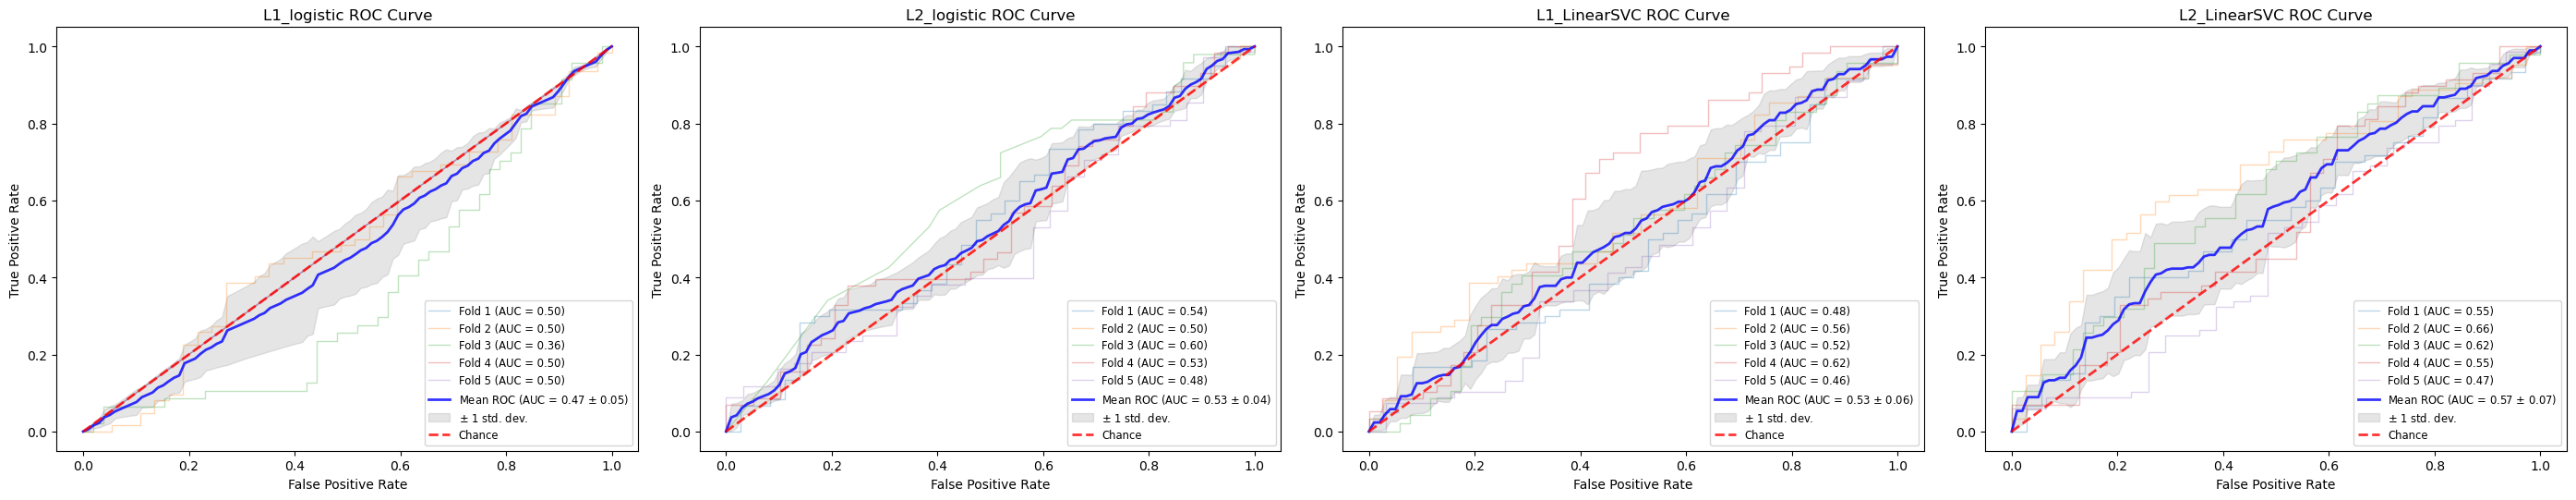

In [49]:
# === 8. Cannabis: Evaluation (Using Pipeline) ===

print("\n" + "="*40)
print("Starting Cannabis Activation Classification - Evaluation (with Pipeline)")
print("="*40 + "\n")

# --- Get Data (No Scaling Here) ---
# Extract unscaled PCA data and labels/IDs using helper functions
print("Extracting Cannabis train/test data...")
try:
    can_X_train = get_train_X(data_dict['cannabis']) # Gets numpy array
    can_y_train = get_train_y(data_dict['cannabis'])
    can_X_test = get_test_X(data_dict['cannabis'])
    can_y_test = get_test_y(data_dict['cannabis'])
    can_train_ids = get_train_ids(data_dict['cannabis']) # For subject-based CV
    if can_X_train.size==0 or can_y_train.size==0 or can_X_test.size==0 or can_y_test.size==0 or can_train_ids.size==0:
         raise ValueError("Cannabis train/test/id data is empty or incomplete.")
    print(f"  Train Shapes (Unscaled): X={can_X_train.shape}, y={can_y_train.shape}, ids={can_train_ids.shape}")
    print(f"  Test Shapes (Unscaled): X={can_X_test.shape}, y={can_y_test.shape}")
except KeyError:
    raise KeyError("Data for 'cannabis' group not found in data_dict.")
except Exception as e:
    raise RuntimeError(f"Error preparing Cannabis data: {e}")


# --- Define BASE Classifiers using Best Alphas ---
# Create instances of the base SGDClassifier, not the pipeline yet
print("\nDefining BASE classifiers using best alphas from grid search...")
classifiers_can_base = {}
# Define structure for iterating variants if not already defined
sgd_variants_eval = [
    {'loss': 'log_loss', 'penalty': 'l1', 'name': 'L1_logistic'},
    {'loss': 'log_loss', 'penalty': 'l2', 'name': 'L2_logistic'},
    {'loss': 'hinge', 'penalty': 'l1', 'name': 'L1_LinearSVC'},
    {'loss': 'hinge', 'penalty': 'l2', 'name': 'L2_LinearSVC'}
]
for variant in sgd_variants_eval:
    combo_key = f"{variant['loss']}_{variant['penalty']}" # Key used in can_best_alphas
    classifier_name = variant['name']
    # Use found alpha or default if not found in grid search results
    best_alpha = can_best_alphas.get(combo_key, 1e-4) # Default alpha if key missing

    classifiers_can_base[classifier_name] = SGDClassifier(
        loss=variant['loss'],
        penalty=variant['penalty'],
        alpha=best_alpha,
        random_state=RANDOM_STATE_PIPELINE, # Use pipeline-specific state
        max_iter=MAX_ITER_TRAINING,        # Use training iterations
        class_weight='balanced'
    )
    print(f"  Defined BASE {classifier_name} with alpha={best_alpha:.6f}")


# --- Run Evaluation Pipeline ---
# Pass the dictionary of BASE classifiers to the pipeline
print("\nRunning evaluation pipeline (includes internal scaling)...")
evaluator_can = EvaluationPipeline(classifiers_can_base) # Pass BASE classifiers

# The run_cv_and_plot method now handles scaling internally via Pipeline
# It returns fitted PIPELINES
fig_can, axes_can, fitted_pipelines_can = evaluator_can.run_cv_and_plot(
    X_train=can_X_train, # Pass UNSCALED train data
    y_train=can_y_train,
    train_ids=can_train_ids,
    num_folds=CLASSIFICATION_CV_FOLDS,
    random_state_kfold=RANDOM_STATE_KFOlD
)

# --- Save ROC Figure ---
try:
    # Ensure parent directory exists
    FIGURE_DIR.mkdir(parents=True, exist_ok=True)
    fig_can.savefig(CAN_ROC_FIG, format='svg', dpi=1200, bbox_inches='tight')
    print(f"\nSaved Cannabis ROC curve figure to {CAN_ROC_FIG}")
except Exception as e:
    logging.error(f"Error saving ROC figure {CAN_ROC_FIG}: {e}", exc_info=True)
# plt.close(fig_can) # Close figure


# --- Display CV Metrics ---
can_metrics_df = evaluator_can.get_cv_metrics_summary()
print("\nCannabis Cross-Validation Metrics Summary:")
display(can_metrics_df) # Use display for nice notebook formatting


# --- Save Final Fitted PIPELINES ---
# The evaluator fits final pipelines on the full UNSCALED training data
evaluator_can.save_fitted_models(CANNABIS_MODEL_PKL) # Saves the dict of pipelines


# --- Evaluate on Hold-Out Test Set using Saved PIPELINES ---
print("\n--- Cannabis Hold-Out Test Set Evaluation (using saved Pipelines) ---")
try:
    # Load the saved dictionary of pipelines
    loaded_pipelines_can = load_pickle(CANNABIS_MODEL_PKL) # Use file_utils function

    if loaded_pipelines_can and isinstance(loaded_pipelines_can, dict):
        print(f"Loaded {len(loaded_pipelines_can)} pipelines for evaluation.")
        for model_name, final_pipeline in loaded_pipelines_can.items():
             # Check if it's a valid Pipeline object
             if final_pipeline and isinstance(final_pipeline, Pipeline):
                 try:
                     # Predict using the loaded PIPELINE on the UNSCALED test data
                     preds_test_can = final_pipeline.predict(can_X_test) # Pass unscaled test data
                     test_acc_can = accuracy_score(can_y_test, preds_test_can)
                     test_cm_can = confusion_matrix(can_y_test, preds_test_can)
                     print(f"\nModel: {model_name}")
                     print(f"  Test Accuracy: {test_acc_can:.4f}")
                     print(f"  Test Confusion Matrix:\n{test_cm_can}")
                 except Exception as e:
                      logging.error(f"\nModel: {model_name} - Error during test prediction/evaluation: {e}", exc_info=True)
             elif final_pipeline is None:
                  print(f"\nModel: {model_name} - Final model fitting failed (was None in saved file).")
             else:
                  print(f"\nModel: {model_name} - Loaded object is not a valid Pipeline (type: {type(final_pipeline).__name__}).")
    else:
        print(f"No valid pipelines loaded from {CANNABIS_MODEL_PKL} for test evaluation.")

except FileNotFoundError:
    logging.error(f"Could not load saved pipelines from {CANNABIS_MODEL_PKL}. File not found.")
except Exception as e:
    logging.error(f"An error occurred loading or evaluating pipelines: {e}", exc_info=True)


print("\n" + "="*40)
print("Finished Cannabis Evaluation (with Pipeline)")
print("="*40 + "\n")

2025-04-21 16:00:40,770 - INFO - Running 5-fold Cross-Evaluation for L1_logistic (with scaling)...
2025-04-21 16:00:40,805 - INFO -   L1_logistic: Mean Cross-Eval Accuracy = 0.5220 +/- 0.1218
2025-04-21 16:00:40,806 - INFO -   L1_logistic: Total Cross-Eval Confusion Matrix (across folds):
[[ 88. 132.]
 [150. 220.]]
2025-04-21 16:00:40,814 - INFO -   Fitted final pipeline for L1_logistic on full training data.
2025-04-21 16:00:40,814 - INFO - Running 5-fold Cross-Evaluation for L2_logistic (with scaling)...
2025-04-21 16:00:40,847 - INFO -   L2_logistic: Mean Cross-Eval Accuracy = 0.5576 +/- 0.0977
2025-04-21 16:00:40,848 - INFO -   L2_logistic: Total Cross-Eval Confusion Matrix (across folds):
[[ 63. 157.]
 [104. 266.]]
2025-04-21 16:00:40,856 - INFO -   Fitted final pipeline for L2_logistic on full training data.
2025-04-21 16:00:40,856 - INFO - Running 5-fold Cross-Evaluation for L1_LinearSVC (with scaling)...
2025-04-21 16:00:40,908 - INFO -   L1_LinearSVC: Mean Cross-Eval Accuracy 


Starting Cross-Classification: Train Alcohol -> Test Cannabis


Applying StandardScaler (Fit on Alcohol Train)...

Defining classifiers using best ALCOHOL alphas...
  Defined L1_logistic with alpha=0.001000
  Defined L2_logistic with alpha=1.000000
  Defined L1_LinearSVC with alpha=0.100000
  Defined L2_LinearSVC with alpha=0.000100

Running cross-evaluation pipeline...


2025-04-21 16:00:40,962 - INFO -   Fitted final pipeline for L1_LinearSVC on full training data.
2025-04-21 16:00:40,962 - INFO - Running 5-fold Cross-Evaluation for L2_LinearSVC (with scaling)...
2025-04-21 16:00:40,988 - INFO -   L2_LinearSVC: Mean Cross-Eval Accuracy = 0.5763 +/- 0.1017
2025-04-21 16:00:40,989 - INFO -   L2_LinearSVC: Total Cross-Eval Confusion Matrix (across folds):
[[ 44. 176.]
 [ 74. 296.]]
2025-04-21 16:00:40,995 - INFO -   Fitted final pipeline for L2_LinearSVC on full training data.



Saved Cross-Eval ROC curve figure to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/activation/cross_roc_train_alc_test_can_activation_pca_full_rank.svg

Cross-Evaluation (Train Alc, Test Can) CV Metrics Summary:


,Estimator,Mean CV Accuracy,Std CV Accuracy,Mean CV AUC,Std CV AUC,Total TP,Total FP,Total FN,Total TN,Overall Precision,Overall Recall (Sensitivity),Overall Specificity,Overall F1-Score
0,L1_logistic,0.5220,0.1218,0.5065,0.0187,220.0,132.0,150.0,88.0,0.6250,0.5946,0.4000,0.6094
1,L2_logistic,0.5576,0.0977,0.5404,0.0296,266.0,157.0,104.0,63.0,0.6288,0.7189,0.2864,0.6709
2,L1_LinearSVC,0.5153,0.0815,0.4878,0.0200,224.0,140.0,146.0,80.0,0.6154,0.6054,0.3636,0.6104
3,L2_LinearSVC,0.5763,0.1017,0.5482,0.0289,296.0,176.0,74.0,44.0,0.6271,0.8000,0.2000,0.7031



Finished Cross-Classification: Train Alcohol -> Test Cannabis



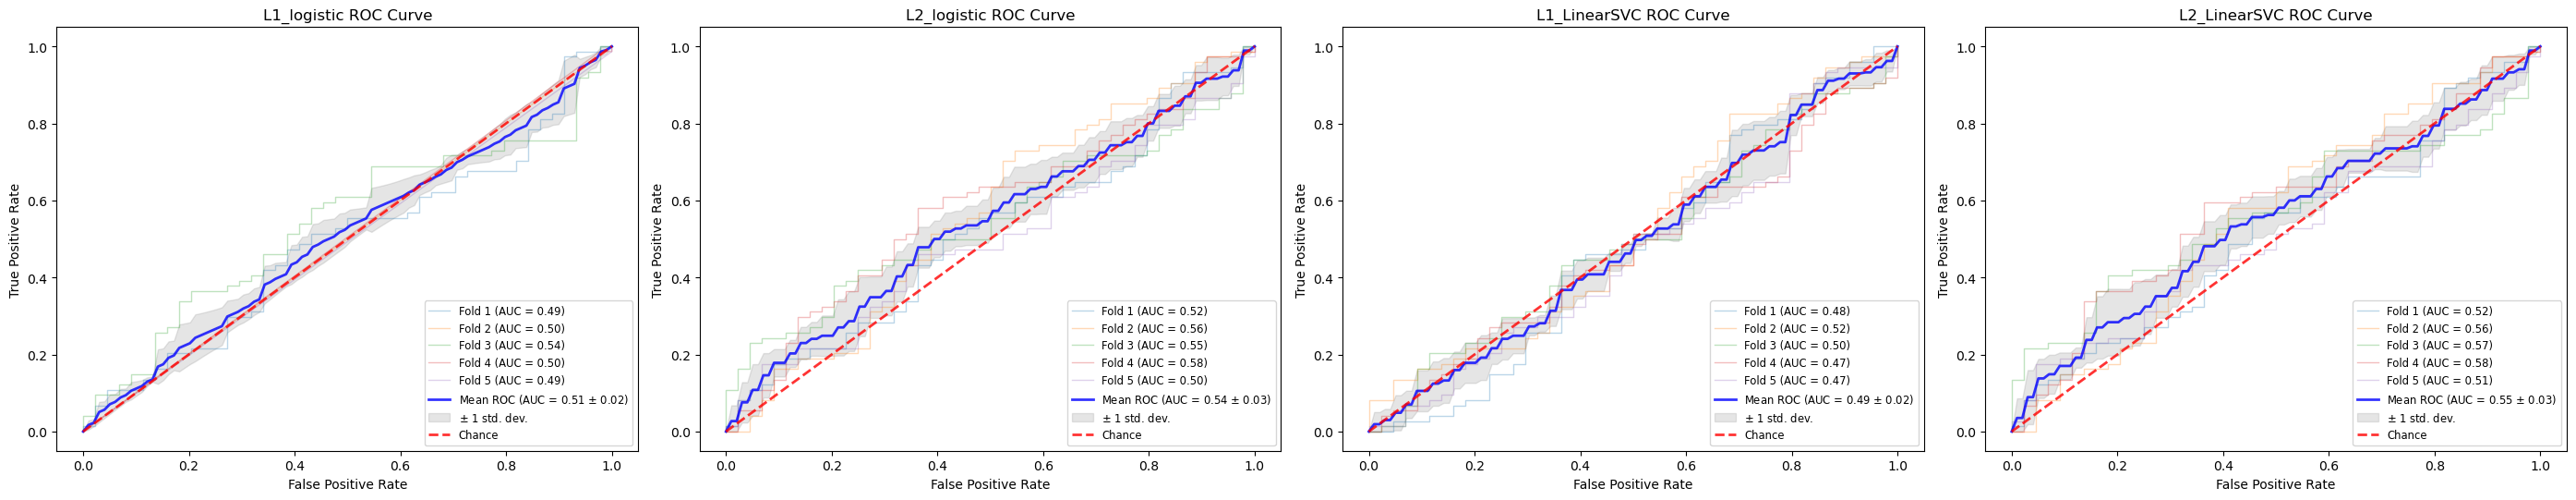

In [50]:
# === 9. Cross-Classification: Train Alcohol, Test Cannabis ===

print("\n" + "="*40)
print("Starting Cross-Classification: Train Alcohol -> Test Cannabis")
print("="*40 + "\n")

# --- Get Data ---
# Use already extracted variables if available, or re-extract
# Train on Alcohol data
alc_X_train = get_train_X(data_dict['alcohol'])
alc_y_train = get_train_y(data_dict['alcohol'])
# Test on Cannabis data
can_X_eval = get_test_X(data_dict['cannabis']) # Using Test portion of Cannabis
can_y_eval = get_test_y(data_dict['cannabis'])
# Optional: Use can_X_train / can_y_train for evaluation if matching original code
# can_X_eval = get_train_X(data_dict['cannabis'])
# can_y_eval = get_train_y(data_dict['cannabis'])

if alc_X_train.size==0 or alc_y_train.size==0 or can_X_eval.size==0 or can_y_eval.size==0:
    raise ValueError("Train (Alc) or Eval (Can) data is empty.")

# --- Scaling (Fit on Train [Alc], Transform BOTH) ---
print("\nApplying StandardScaler (Fit on Alcohol Train)...")
scaler_cross_alc_can = StandardScaler()
alc_X_train_scaled = scaler_cross_alc_can.fit_transform(alc_X_train)
can_X_eval_scaled = scaler_cross_alc_can.transform(can_X_eval) # Transform Can data

# --- Define Classifiers (Using Alcohol's Best Alphas) ---
print("\nDefining classifiers using best ALCOHOL alphas...")
classifiers_cross_alc_can = {}
for variant in sgd_variants_eval:
    combo_key = f"{variant['loss']}_{variant['penalty']}"
    classifier_name = variant['name']
    best_alpha = alc_best_alphas.get(combo_key, 1e-4) # Use ALCOHOL alphas
    classifiers_cross_alc_can[classifier_name] = SGDClassifier(
        loss=variant['loss'], penalty=variant['penalty'], alpha=best_alpha,
        random_state=RANDOM_STATE_CROSS, max_iter=MAX_ITER_TRAINING, class_weight='balanced'
    )
    print(f"  Defined {classifier_name} with alpha={best_alpha:.6f}")

# --- Run Cross-Evaluation Pipeline ---
print("\nRunning cross-evaluation pipeline...")
cross_evaluator_alc_can = CrossEvaluationPipeline(classifiers_cross_alc_can)
# CV folds are on Alcohol train data; evaluation happens on Cannabis test data
fig_cross_alc_can, _, fitted_cross_alc_can = cross_evaluator_alc_can.run_cross_cv_and_plot(
    X_train=alc_X_train_scaled, # Scaled Alc Train
    y_train=alc_y_train,
    X_eval=can_X_eval_scaled,   # Scaled Can Eval
    y_eval=can_y_eval,
    num_folds=CLASSIFICATION_CV_FOLDS,
    random_state_kfold=RANDOM_STATE_KFOlD # Use consistent state for CV split on train data
)

# --- Save/Display Results ---
# Define specific output paths in Config if desired
cross_alc_can_roc_path = FIGURE_DIR / f"cross_roc_train_alc_test_can_activation_pca_{PCA_TYPE}.svg"
try: fig_cross_alc_can.savefig(cross_alc_can_roc_path, format='svg', dpi=1200, bbox_inches='tight'); print(f"\nSaved Cross-Eval ROC curve figure to {cross_alc_can_roc_path}")
except Exception as e: print(f"Error saving ROC figure: {e}")
# plt.close(fig_cross_alc_can)

cross_metrics_alc_can = cross_evaluator_alc_can.get_cv_metrics_summary()
print("\nCross-Evaluation (Train Alc, Test Can) CV Metrics Summary:")
display(cross_metrics_alc_can)

# Optional: Save fitted models (trained on FULL scaled Alc data)
# cross_evaluator_alc_can.save_fitted_models(MODELS_DIR / "cross_activation_train_alc.pkl")

print("\n" + "="*40)
print("Finished Cross-Classification: Train Alcohol -> Test Cannabis")
print("="*40 + "\n")

2025-04-21 16:00:42,962 - INFO - Running 5-fold Cross-Evaluation for L1_logistic (with scaling)...



Starting Cross-Classification: Train Cannabis -> Test Alcohol


Applying StandardScaler (Fit on Cannabis Train)...

Defining classifiers using best CANNABIS alphas...
  Defined L1_logistic with alpha=0.100000
  Defined L2_logistic with alpha=0.010000
  Defined L1_LinearSVC with alpha=0.010000
  Defined L2_LinearSVC with alpha=1.000000

Running cross-evaluation pipeline...


2025-04-21 16:00:43,157 - INFO -   L1_logistic: Mean Cross-Eval Accuracy = 0.5017 +/- 0.0083
2025-04-21 16:00:43,158 - INFO -   L1_logistic: Total Cross-Eval Confusion Matrix (across folds):
[[58. 87.]
 [60. 90.]]
2025-04-21 16:00:43,194 - INFO -   Fitted final pipeline for L1_logistic on full training data.
2025-04-21 16:00:43,195 - INFO - Running 5-fold Cross-Evaluation for L2_logistic (with scaling)...
2025-04-21 16:00:43,260 - INFO -   L2_logistic: Mean Cross-Eval Accuracy = 0.5017 +/- 0.0083
2025-04-21 16:00:43,260 - INFO -   L2_logistic: Total Cross-Eval Confusion Matrix (across folds):
[[58. 87.]
 [60. 90.]]
2025-04-21 16:00:43,278 - INFO -   Fitted final pipeline for L2_logistic on full training data.
2025-04-21 16:00:43,279 - INFO - Running 5-fold Cross-Evaluation for L1_LinearSVC (with scaling)...
2025-04-21 16:00:43,354 - INFO -   L1_LinearSVC: Mean Cross-Eval Accuracy = 0.4983 +/- 0.0230
2025-04-21 16:00:43,354 - INFO -   L1_LinearSVC: Total Cross-Eval Confusion Matrix (acr


Saved Cross-Eval ROC curve figure to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/activation/cross_roc_train_can_test_alc_activation_pca_full_rank.svg

Cross-Evaluation (Train Can, Test Alc) CV Metrics Summary:


,Estimator,Mean CV Accuracy,Std CV Accuracy,Mean CV AUC,Std CV AUC,Total TP,Total FP,Total FN,Total TN,Overall Precision,Overall Recall (Sensitivity),Overall Specificity,Overall F1-Score
0,L1_logistic,0.5017,0.0083,0.4869,0.0262,90.0,87.0,60.0,58.0,0.5085,0.6000,0.4000,0.5505
1,L2_logistic,0.5017,0.0083,0.5821,0.0440,90.0,87.0,60.0,58.0,0.5085,0.6000,0.4000,0.5505
2,L1_LinearSVC,0.4983,0.0230,0.5487,0.0555,55.0,53.0,95.0,92.0,0.5093,0.3667,0.6345,0.4264
3,L2_LinearSVC,0.5085,0.0000,0.6025,0.0321,150.0,145.0,0.0,0.0,0.5085,1.0000,0.0000,0.6742



Finished Cross-Classification: Train Cannabis -> Test Alcohol



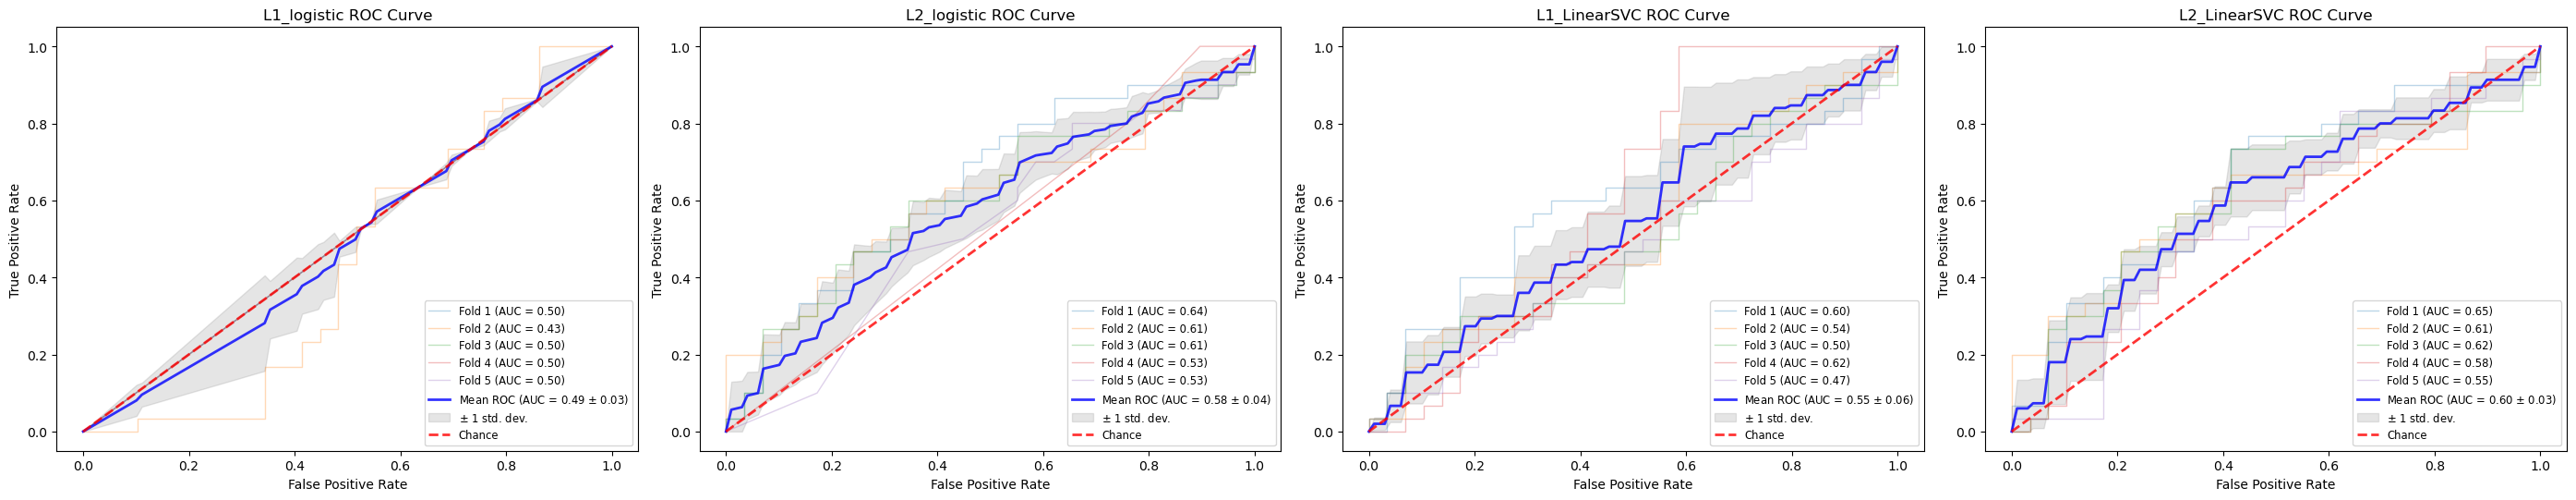

In [51]:
# === 10. Cross-Classification: Train Cannabis, Test Alcohol ===

print("\n" + "="*40)
print("Starting Cross-Classification: Train Cannabis -> Test Alcohol")
print("="*40 + "\n")

# --- Get Data ---
can_X_train = get_train_X(data_dict['cannabis'])
can_y_train = get_train_y(data_dict['cannabis'])
alc_X_eval = get_test_X(data_dict['alcohol']) # Using Test portion of Alcohol
alc_y_eval = get_test_y(data_dict['alcohol'])
if can_X_train.size==0 or can_y_train.size==0 or alc_X_eval.size==0 or alc_y_eval.size==0:
    raise ValueError("Train (Can) or Eval (Alc) data is empty.")

# --- Scaling (Fit on Train [Can], Transform BOTH) ---
print("\nApplying StandardScaler (Fit on Cannabis Train)...")
scaler_cross_can_alc = StandardScaler()
can_X_train_scaled = scaler_cross_can_alc.fit_transform(can_X_train)
alc_X_eval_scaled = scaler_cross_can_alc.transform(alc_X_eval) # Transform Alc data

# --- Define Classifiers (Using Cannabis's Best Alphas) ---
print("\nDefining classifiers using best CANNABIS alphas...")
classifiers_cross_can_alc = {}
for variant in sgd_variants_eval:
    combo_key = f"{variant['loss']}_{variant['penalty']}"
    classifier_name = variant['name']
    best_alpha = can_best_alphas.get(combo_key, 1e-4) # Use CANNABIS alphas
    classifiers_cross_can_alc[classifier_name] = SGDClassifier(
        loss=variant['loss'], penalty=variant['penalty'], alpha=best_alpha,
        random_state=RANDOM_STATE_CROSS, max_iter=MAX_ITER_TRAINING, class_weight='balanced'
    )
    print(f"  Defined {classifier_name} with alpha={best_alpha:.6f}")

# --- Run Cross-Evaluation Pipeline ---
print("\nRunning cross-evaluation pipeline...")
cross_evaluator_can_alc = CrossEvaluationPipeline(classifiers_cross_can_alc)
fig_cross_can_alc, _, fitted_cross_can_alc = cross_evaluator_can_alc.run_cross_cv_and_plot(
    X_train=can_X_train_scaled, # Scaled Can Train
    y_train=can_y_train,
    X_eval=alc_X_eval_scaled,   # Scaled Alc Eval
    y_eval=alc_y_eval,
    num_folds=CLASSIFICATION_CV_FOLDS,
    random_state_kfold=RANDOM_STATE_KFOlD
)

# --- Save/Display Results ---
cross_can_alc_roc_path = FIGURE_DIR / f"cross_roc_train_can_test_alc_activation_pca_{PCA_TYPE}.svg"
try: fig_cross_can_alc.savefig(cross_can_alc_roc_path, format='svg', dpi=1200, bbox_inches='tight'); print(f"\nSaved Cross-Eval ROC curve figure to {cross_can_alc_roc_path}")
except Exception as e: print(f"Error saving ROC figure: {e}")
# plt.close(fig_cross_can_alc)

cross_metrics_can_alc = cross_evaluator_can_alc.get_cv_metrics_summary()
print("\nCross-Evaluation (Train Can, Test Alc) CV Metrics Summary:")
display(cross_metrics_can_alc)

# Optional: Save fitted models (trained on FULL scaled Can data)
# cross_evaluator_can_alc.save_fitted_models(MODELS_DIR / "cross_activation_train_can.pkl")

print("\n" + "="*40)
print("Finished Cross-Classification: Train Cannabis -> Test Alcohol")
print("="*40 + "\n")

In [52]:
# === 11. Aggregated Data Preparation ===
# Combine Alcohol and Cannabis data (post-PCA) for aggregated analysis.
# Note: If PCA was run separately, combining components might not be optimal.
# Ideally, PCA should be run on the combined *raw* data.
# This cell assumes PCA was run separately per group, and we combine the *reduced* data.

print("\n" + "="*40)
print("Preparing Aggregated Activation Data")
print("="*40 + "\n")

# --- Combine Reduced Data ---
try:
    alc_data = data_dict['alcohol']
    can_data = data_dict['cannabis']

    # Check if reduced matrices have the same number of components
    n_comp_alc = alc_data['reduced_img_matrix'].shape[1]
    n_comp_can = can_data['reduced_img_matrix'].shape[1]
    if n_comp_alc != n_comp_can:
         # This happens if PCA type was %var and resulted in different component counts
         # Need a strategy: Use min components, rerun PCA on combined, or error out.
         # Let's raise an error for now, as combining is problematic.
         raise ValueError(f"Cannot aggregate PCA data: Alcohol has {n_comp_alc} components, Cannabis has {n_comp_can}.")

    # Concatenate PCA data, labels, training flags, subject names
    agg_X_reduced = pd.concat([alc_data['reduced_img_matrix'], can_data['reduced_img_matrix']], ignore_index=True)
    agg_labels = np.concatenate([alc_data['labels'], can_data['labels']])
    agg_training_flags = np.concatenate([alc_data['training'], can_data['training']]) # Boolean masks
    agg_sub_names = np.concatenate([alc_data['sub_names'], can_data['sub_names']]) # For train IDs later

    agg_training_mask = agg_training_flags.astype(bool)
    agg_testing_mask = ~agg_training_mask

    # Create final train/test splits for aggregated data
    agg_X_train = agg_X_reduced.values[agg_training_mask]
    agg_y_train = agg_labels[agg_training_mask]
    agg_X_test = agg_X_reduced.values[agg_testing_mask]
    agg_y_test = agg_labels[agg_testing_mask]
    agg_train_ids = agg_sub_names[agg_training_mask] # Subject IDs for CV grouping

    print("Created Aggregated Train/Test sets from reduced data:")
    print(f"  Train: X={agg_X_train.shape}, y={agg_y_train.shape}, ids={agg_train_ids.shape}")
    print(f"  Test: X={agg_X_test.shape}, y={agg_y_test.shape}")

except KeyError as e:
    raise KeyError(f"Missing data for 'alcohol' or 'cannabis' group in data_dict: {e}")
except Exception as e:
    raise RuntimeError(f"Error during aggregated data preparation: {e}")

print("\n" + "="*40)
print("Finished Aggregated Data Preparation")
print("="*40 + "\n")


Preparing Aggregated Activation Data

Created Aggregated Train/Test sets from reduced data:
  Train: X=(712, 889), y=(712,), ids=(712,)
  Test: X=(177, 889), y=(177,)

Finished Aggregated Data Preparation



In [53]:
# === 12. Aggregated: Grid Search (Using Pipeline) ===

print("\n" + "="*40)
print("Starting Aggregated Activation Classification - Grid Search (with Pipeline)")
print("="*40 + "\n")

# --- Grid Search Setup ---
# Parameter grid MUST use 'estimator__' prefix for the SGDClassifier step in the pipeline
param_grid_sgd_pipeline = {
    'estimator__loss': ['hinge', 'log_loss'],
    'estimator__penalty': ['l2', 'l1'],
    'estimator__alpha': SGD_ALPHAS_GRID # Use alpha grid from config
}

# Instantiate CustomGridSearch (which now expects prefixed params and runs a Pipeline)
gs_runner_agg = CustomGridSearch(
    param_grid=param_grid_sgd_pipeline, # Pass the prefixed grid
    random_state=RANDOM_STATE_GRIDSEARCH,
    max_iter=MAX_ITER_GRIDSEARCH
)
print(f"\nRunning GridSearchCV for Pipeline on Aggregated Activation Data (Shape: {agg_X_train.shape})...")
# Pass the unscaled aggregated data to run_search
gs_runner_agg.run_search(
    agg_X_train, # Pass unscaled aggregated train data
    agg_y_train,
    cv=GRIDSEARCH_CV_FOLDS,
    scoring='accuracy', # Or 'roc_auc'
    n_jobs=-1,
    verbose=1
)

# --- Extract Best Alphas ---
# get_best_alphas still returns keys like 'log_loss_l1' based on the internal logic
agg_best_alphas = gs_runner_agg.get_best_alphas()
print("\nBest Alphas Found (Aggregated):")
if agg_best_alphas:
    alphas_df_agg = pd.DataFrame(agg_best_alphas, index=['best_alpha']).T
    alphas_df_agg.index.name = 'Loss_Penalty'
    display(alphas_df_agg)
else:
    print("  No best alphas extracted (grid search may have failed). Using defaults.")
    agg_best_alphas = {'log_loss_l1': 1e-4, 'log_loss_l2': 1e-4, 'hinge_l1': 1e-4, 'hinge_l2': 1e-4}

# Optional: Get the single best overall pipeline and its params
# best_pipeline_agg = gs_runner_agg.get_best_overall_pipeline()
# best_pipeline_params_agg = gs_runner_agg.get_best_overall_params()
# print("\nBest Overall Pipeline Params (Aggregated):")
# print(best_pipeline_params_agg)


print("\n" + "="*40)
print("Finished Aggregated Grid Search (with Pipeline)")
print("="*40 + "\n")

2025-04-21 16:00:51,283 - INFO - Running GridSearchCV for Pipeline(StandardScaler, SGDClassifier)...



Starting Aggregated Activation Classification - Grid Search (with Pipeline)


Running GridSearchCV for Pipeline on Aggregated Activation Data (Shape: (712, 889))...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


2025-04-21 16:00:53,996 - INFO - GridSearchCV finished in 2.71 seconds.
2025-04-21 16:00:53,996 - INFO - Best overall pipeline score: 0.5702
2025-04-21 16:00:53,996 - INFO - Best overall pipeline params: {'estimator__alpha': 1.0, 'estimator__loss': 'hinge', 'estimator__penalty': 'l2'}
2025-04-21 16:00:53,997 - INFO - Best alpha for hinge_l2: 1.00000 (score: 0.5702)
2025-04-21 16:00:53,998 - INFO - Best alpha for hinge_l1: 0.01000 (score: 0.5156)
2025-04-21 16:00:53,999 - INFO - Best alpha for log_loss_l2: 0.01000 (score: 0.5407)
2025-04-21 16:00:54,000 - INFO - Best alpha for log_loss_l1: 0.01000 (score: 0.5238)



Best Alphas Found (Aggregated):


,best_alpha
Loss_Penalty,
hinge_l2,1.00
hinge_l1,0.01
log_loss_l2,0.01
log_loss_l1,0.01



Finished Aggregated Grid Search (with Pipeline)



2025-04-21 16:00:55,329 - INFO - Running 5-fold CV for L1_logistic (with scaling)...
2025-04-21 16:00:55,499 - INFO -   L1_logistic: Mean CV Accuracy = 0.5117 +/- 0.0436
2025-04-21 16:00:55,499 - INFO -   L1_logistic: Total Confusion Matrix (across folds):
[[143. 164.]
 [183. 222.]]



Starting Aggregated Activation Classification - Evaluation


Applying StandardScaler to aggregated train/test sets...
Saved Aggregated scaler to /Users/kulkarnik/LocalProjects/multiclassifier_repo/models/activation/aggregated_activation_scaler.joblib

Defining classifiers using best aggregated alphas...
  Defined L1_logistic with alpha=0.010000
  Defined L2_logistic with alpha=0.010000
  Defined L1_LinearSVC with alpha=0.010000
  Defined L2_LinearSVC with alpha=1.000000

Running evaluation pipeline...


2025-04-21 16:00:55,538 - INFO -   Fitted final pipeline for L1_logistic on full training data.
2025-04-21 16:00:55,539 - INFO - Running 5-fold CV for L2_logistic (with scaling)...
2025-04-21 16:00:55,633 - INFO -   L2_logistic: Mean CV Accuracy = 0.5578 +/- 0.0672
2025-04-21 16:00:55,634 - INFO -   L2_logistic: Total Confusion Matrix (across folds):
[[141. 166.]
 [150. 255.]]
2025-04-21 16:00:55,655 - INFO -   Fitted final pipeline for L2_logistic on full training data.
2025-04-21 16:00:55,655 - INFO - Running 5-fold CV for L1_LinearSVC (with scaling)...
2025-04-21 16:00:55,755 - INFO -   L1_LinearSVC: Mean CV Accuracy = 0.5069 +/- 0.0326
2025-04-21 16:00:55,756 - INFO -   L1_LinearSVC: Total Confusion Matrix (across folds):
[[145. 162.]
 [189. 216.]]
2025-04-21 16:00:55,779 - INFO -   Fitted final pipeline for L1_LinearSVC on full training data.
2025-04-21 16:00:55,780 - INFO - Running 5-fold CV for L2_LinearSVC (with scaling)...
2025-04-21 16:00:55,953 - INFO -   L2_LinearSVC: Mean 


Saved Aggregated ROC curve figure to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/activation/agg_roc_activation_pca_full_rank.svg

Aggregated Cross-Validation Metrics Summary:


,Estimator,Mean CV Accuracy,Std CV Accuracy,Mean CV AUC,Std CV AUC,Total TP,Total FP,Total FN,Total TN,Overall Precision,Overall Recall (Sensitivity),Overall Specificity,Overall F1-Score
0,L1_logistic,0.5117,0.0436,0.5156,0.0482,222.0,164.0,183.0,143.0,0.5751,0.5481,0.4658,0.5613
1,L2_logistic,0.5578,0.0672,0.4735,0.0070,255.0,166.0,150.0,141.0,0.6057,0.6296,0.4593,0.6174
2,L1_LinearSVC,0.5069,0.0326,0.4818,0.0475,216.0,162.0,189.0,145.0,0.5714,0.5333,0.4723,0.5517
3,L2_LinearSVC,0.5684,0.0489,0.4681,0.0056,403.0,306.0,2.0,1.0,0.5684,0.9951,0.0033,0.7235


2025-04-21 16:00:56,334 - INFO - Saved final fitted pipelines to /Users/kulkarnik/LocalProjects/multiclassifier_repo/models/activation/aggregated_activation_pca_full_rank_classifiers.pkl



--- Aggregated Hold-Out Test Set Evaluation ---

Model: L1_logistic
  Test Accuracy: 0.5028
  Test Confusion Matrix:
[[23 50]
 [38 66]]

Model: L2_logistic
  Test Accuracy: 0.5876
  Test Confusion Matrix:
[[  0  73]
 [  0 104]]

Model: L1_LinearSVC
  Test Accuracy: 0.5424
  Test Confusion Matrix:
[[32 41]
 [40 64]]

Model: L2_LinearSVC
  Test Accuracy: 0.5876
  Test Confusion Matrix:
[[  0  73]
 [  0 104]]

Finished Aggregated Evaluation



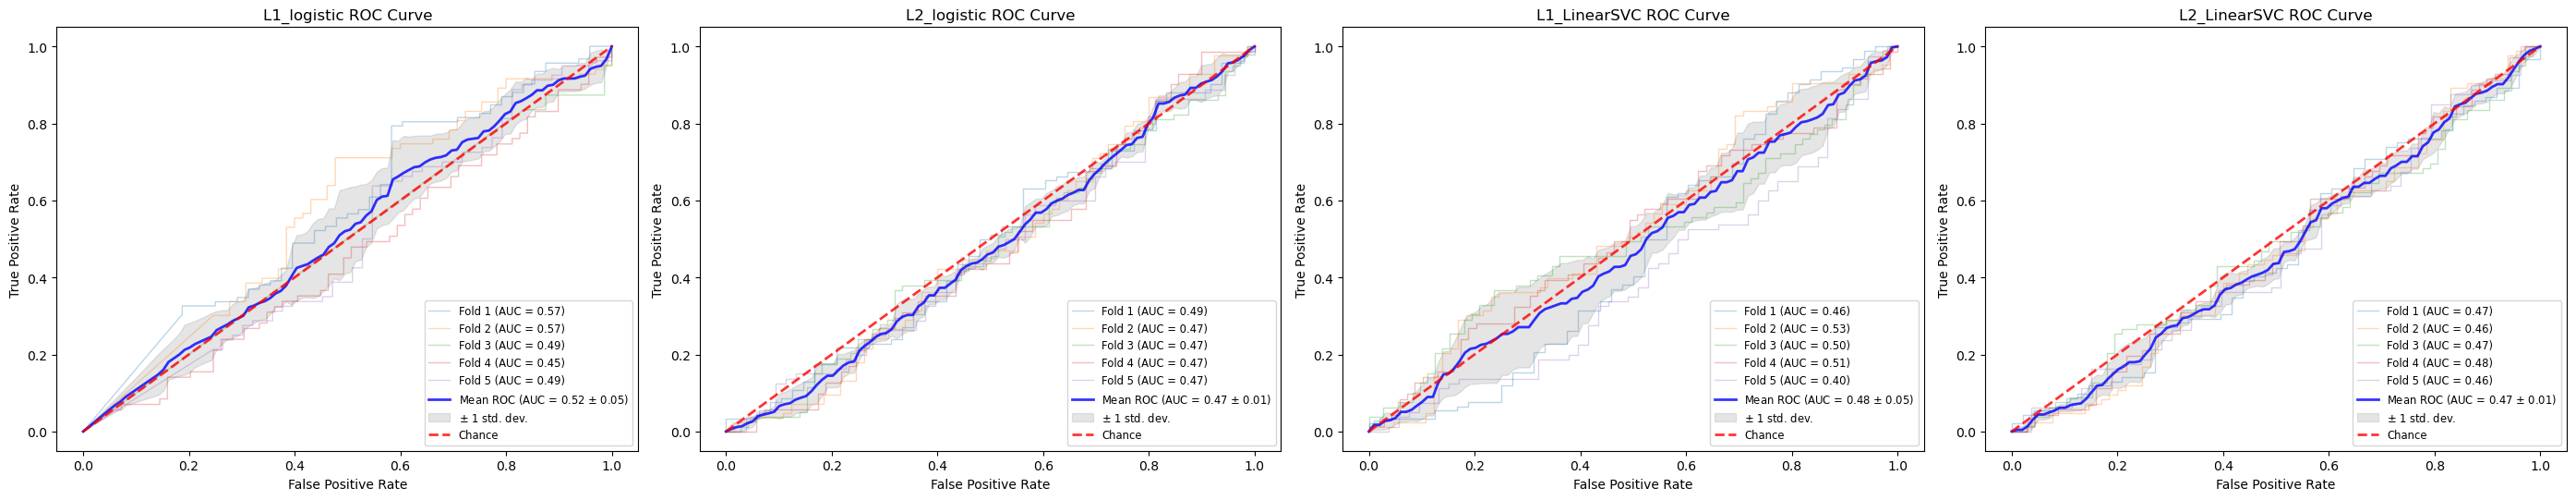

In [54]:
# === 13. Aggregated: Evaluation ===

print("\n" + "="*40)
print("Starting Aggregated Activation Classification - Evaluation")
print("="*40 + "\n")

# --- Scaling (Optional but recommended) ---
print("\nApplying StandardScaler to aggregated train/test sets...")
scaler_eval_agg = StandardScaler()
agg_X_train_scaled = scaler_eval_agg.fit_transform(agg_X_train)
agg_X_test_scaled = scaler_eval_agg.transform(agg_X_test)
agg_scaler_path = MODELS_DIR / "aggregated_activation_scaler.joblib"
try: joblib.dump(scaler_eval_agg, agg_scaler_path); print(f"Saved Aggregated scaler to {agg_scaler_path}")
except Exception as e: print(f"Warning: Could not save scaler: {e}")


# --- Define Classifiers ---
print("\nDefining classifiers using best aggregated alphas...")
classifiers_agg = {}
for variant in sgd_variants_eval: # Reuse variant list
    combo_key = f"{variant['loss']}_{variant['penalty']}"
    classifier_name = variant['name']
    best_alpha = agg_best_alphas.get(combo_key, 1e-4)
    classifiers_agg[classifier_name] = SGDClassifier(
        loss=variant['loss'], penalty=variant['penalty'], alpha=best_alpha,
        random_state=RANDOM_STATE_AGG, max_iter=MAX_ITER_TRAINING, class_weight='balanced'
    )
    print(f"  Defined {classifier_name} with alpha={best_alpha:.6f}")

# --- Run Evaluation Pipeline ---
print("\nRunning evaluation pipeline...")
evaluator_agg = EvaluationPipeline(classifiers_agg)
fig_agg, axes_agg, fitted_classifiers_agg = evaluator_agg.run_cv_and_plot(
    X_train=agg_X_train_scaled, # Use scaled data
    y_train=agg_y_train,
    train_ids=agg_train_ids, # Use aggregated subject IDs
    num_folds=CLASSIFICATION_CV_FOLDS,
    random_state_kfold=RANDOM_STATE_KFOlD
)

# --- Save ROC Figure ---
# Define path in Config or here
agg_roc_path = FIGURE_DIR / f"agg_roc_activation_pca_{PCA_TYPE}.svg"
try: fig_agg.savefig(agg_roc_path, format='svg', dpi=1200, bbox_inches='tight'); print(f"\nSaved Aggregated ROC curve figure to {agg_roc_path}")
except Exception as e: print(f"Error saving ROC figure: {e}")
# plt.close(fig_agg)

# --- Display CV Metrics ---
agg_metrics_df = evaluator_agg.get_cv_metrics_summary()
print("\nAggregated Cross-Validation Metrics Summary:")
display(agg_metrics_df)

# --- Save Final Fitted Models ---
evaluator_agg.save_fitted_models(AGGREGATED_MODEL_PKL)

# --- Evaluate on Hold-Out Test Set ---
print("\n--- Aggregated Hold-Out Test Set Evaluation ---")
if fitted_classifiers_agg:
    for model_name, final_model in fitted_classifiers_agg.items():
         if final_model:
             try:
                 preds_test_agg = final_model.predict(agg_X_test_scaled)
                 test_acc_agg = accuracy_score(agg_y_test, preds_test_agg)
                 test_cm_agg = confusion_matrix(agg_y_test, preds_test_agg)
                 print(f"\nModel: {model_name}")
                 print(f"  Test Accuracy: {test_acc_agg:.4f}")
                 print(f"  Test Confusion Matrix:\n{test_cm_agg}")
             except Exception as e: print(f"\nModel: {model_name} - Error during test evaluation: {e}")
         else: print(f"\nModel: {model_name} - Final model fitting failed.")
else: print("No final Aggregated models were fitted successfully.")


print("\n" + "="*40)
print("Finished Aggregated Evaluation")
print("="*40 + "\n")

In [55]:
# === 14. Prepare 3-Way Classification Data (Activation) ===
# This cell combines the loaded alcohol and cannabis data (post-PCA)
# into single train/test sets suitable for 3-way classification.

print("\n" + "="*40)
print("Starting 3-Way Activation Data Preparation")
print("="*40 + "\n")

# --- Define Labels ---
HC_LABEL_INT = 0 # Assuming HC is index 0
ALCOHOL_LABEL_INT = ALCOHOL_CLASS_LABEL_MULTI # From config
CANNABIS_LABEL_INT = CANNABIS_CLASS_LABEL_MULTI # From config
print(f"Using Integer Labels: HC={HC_LABEL_INT}, Cannabis={CANNABIS_LABEL_INT}, Alcohol={ALCOHOL_LABEL_INT}")

# --- Combine Data and Assign 3-Way Labels ---
try:
    alc_data = data_dict['alcohol']
    can_data = data_dict['cannabis']

    # Check if reduced matrices exist and component consistency
    if 'reduced_img_matrix' not in alc_data or 'reduced_img_matrix' not in can_data:
        raise KeyError("Missing 'reduced_img_matrix' for alcohol or cannabis group.")
    n_comp_alc = alc_data['reduced_img_matrix'].shape[1]
    n_comp_can = can_data['reduced_img_matrix'].shape[1]
    if n_comp_alc != n_comp_can:
        raise ValueError(f"Cannot combine for 3-way: Alcohol has {n_comp_alc} components, Cannabis has {n_comp_can}.")

    # Concatenate PCA data (as DataFrames first for potential index safety, then get values)
    three_X_reduced = pd.concat([alc_data['reduced_img_matrix'], can_data['reduced_img_matrix']], ignore_index=True).values # Get numpy array

    # Concatenate original 0/1 labels and training flags
    orig_labels_combined = np.concatenate([alc_data['labels'], can_data['labels']])
    training_flags_combined = np.concatenate([alc_data['training'], can_data['training']])

    # Create group identifiers (assuming Alc first, then Can in data_dict ordering)
    n_alc_runs = len(alc_data['labels'])
    n_can_runs = len(can_data['labels'])
    is_alcohol_run = np.concatenate([np.ones(n_alc_runs, dtype=bool), np.zeros(n_can_runs, dtype=bool)])
    is_cannabis_run = ~is_alcohol_run

    # Assign 3-way labels based on group and original 0/1 label
    three_y = np.full(len(orig_labels_combined), HC_LABEL_INT, dtype=int) # Default to HC
    three_y[(is_alcohol_run) & (orig_labels_combined == 1)] = ALCOHOL_LABEL_INT
    three_y[(is_cannabis_run) & (orig_labels_combined == 1)] = CANNABIS_LABEL_INT

    # Verify label distribution
    unique_3way, counts_3way = np.unique(three_y, return_counts=True)
    print("\nAssigned 3-Way Labels (Combined Data):")
    label_dist_str = ", ".join([f"{MULTICLASS_LABELS[lbl]} ({lbl}): {cnt}" for lbl, cnt in zip(unique_3way, counts_3way)])
    print(f"  Distribution: {label_dist_str}")


    # --- Split into Train/Test ---
    three_training_mask = training_flags_combined.astype(bool)
    three_testing_mask = ~three_training_mask

    three_X_train = three_X_reduced[three_training_mask] # This is the UNSCALED combined PCA train data
    three_y_train = three_y[three_training_mask]
    three_X_test = three_X_reduced[three_testing_mask]   # This is the UNSCALED combined PCA test data
    three_y_test = three_y[three_testing_mask]

    # --- Verification ---
    print("\nCreated 3-Way Train/Test Sets (Post-PCA, Unscaled):")
    print(f"  Train: X={three_X_train.shape}, y={three_y_train.shape}")
    print(f"  Test: X={three_X_test.shape}, y={three_y_test.shape}")
    unique_train, counts_train = np.unique(three_y_train, return_counts=True)
    unique_test, counts_test = np.unique(three_y_test, return_counts=True)
    print(f"  Train Label Distribution: {dict(zip(unique_train, counts_train))}")
    print(f"  Test Label Distribution: {dict(zip(unique_test, counts_test))}")

except KeyError as e:
    raise KeyError(f"Missing required data for 'alcohol' or 'cannabis' group in data_dict: {e}")
except Exception as e:
    raise RuntimeError(f"Error during 3-way data preparation: {e}")

print("\n" + "="*40)
print("Finished 3-Way Activation Data Preparation")
print("="*40 + "\n")


Starting 3-Way Activation Data Preparation

Using Integer Labels: HC=0, Cannabis=1, Alcohol=2

Assigned 3-Way Labels (Combined Data):
  Distribution: HC (0): 380, Cannabis (1): 369, Alcohol (2): 140

Created 3-Way Train/Test Sets (Post-PCA, Unscaled):
  Train: X=(712, 889), y=(712,)
  Test: X=(177, 889), y=(177,)
  Train Label Distribution: {0: 307, 1: 295, 2: 110}
  Test Label Distribution: {0: 73, 1: 74, 2: 30}

Finished 3-Way Activation Data Preparation



In [56]:
# === 15. 3-Way Classification: Grid Search (OneVsRest Strategy - with Pipeline) ===

print("\n" + "="*40)
print("Starting 3-Way Activation Classification - Grid Search (OneVsRest - with Pipeline)")
print("="*40 + "\n")


# --- Grid Search Setup ---
# Define the base estimator
base_sgd_for_ovr = SGDClassifier(
    random_state=RANDOM_STATE_GRIDSEARCH,
    max_iter=MAX_ITER_GRIDSEARCH,
    class_weight='balanced'
)
# Wrap the base estimator in OVR
ovr_base_clf = OneVsRestClassifier(base_sgd_for_ovr)

# Create the outer pipeline including scaling and the OVR classifier
pipeline_ovr = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', ovr_base_clf) # Name the OVR step 'estimator'
])

# Define the parameter grid for the BASE SGDClassifier INSIDE the OVR classifier
# Requires double underscore notation: pipeline-step__ovr-parameter__sgd-parameter
param_grid_ovr_pipeline = {
    'estimator__estimator__loss': ['hinge', 'log_loss'],     # OVR step -> SGD step -> loss
    'estimator__estimator__penalty': ['l2', 'l1'],            # OVR step -> SGD step -> penalty
    'estimator__estimator__alpha': SGD_ALPHAS_GRID          # OVR step -> SGD step -> alpha
}

print(f"Running GridSearchCV for Pipeline(Scaler, OVR(SGD)) on data shape {three_X_train.shape}...")
# Perform GridSearchCV on the OUTER pipeline
grid_search_ovr_pipe = GridSearchCV(
    estimator=pipeline_ovr, # Pass the full pipeline
    param_grid=param_grid_ovr_pipeline, # Pass the doubly-prefixed grid
    cv=GRIDSEARCH_CV_FOLDS, # Stratified K-Fold is default
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit using the unscaled 3-way training data
grid_search_ovr_pipe.fit(three_X_train, three_y_train)

# --- Store Best Parameters ---
# These are the best parameters for the OUTER pipeline
best_params_ovr_pipeline = grid_search_ovr_pipe.best_params_
best_score_ovr = grid_search_ovr_pipe.best_score_
print("\nBest Parameters found for the OVR Pipeline:")
print(f"  Best Score (CV Accuracy): {best_score_ovr:.4f}")
print(f"  Best Pipeline Params: {best_params_ovr_pipeline}")

# Extract the best params specifically for the SGD estimator for later use
best_params_ovr_sgd_cleaned = {
    key.replace('estimator__estimator__', ''): value
    for key, value in best_params_ovr_pipeline.items()
    if key.startswith('estimator__estimator__')
}
print("\nCleaned Best Params for SGD inside OVR:")
print(f"  {best_params_ovr_sgd_cleaned}")


print("\n" + "="*40)
print("Finished 3-Way Grid Search (OneVsRest - with Pipeline)")
print("="*40 + "\n")


Starting 3-Way Activation Classification - Grid Search (OneVsRest - with Pipeline)

Running GridSearchCV for Pipeline(Scaler, OVR(SGD)) on data shape (712, 889)...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Parameters found for the OVR Pipeline:
  Best Score (CV Accuracy): 0.4915
  Best Pipeline Params: {'estimator__estimator__alpha': 0.1, 'estimator__estimator__loss': 'log_loss', 'estimator__estimator__penalty': 'l1'}

Cleaned Best Params for SGD inside OVR:
  {'alpha': 0.1, 'loss': 'log_loss', 'penalty': 'l1'}

Finished 3-Way Grid Search (OneVsRest - with Pipeline)



2025-04-21 16:01:11,095 - INFO - Running 5-fold Stratified CV for OVR_Pipeline_Best...



Starting 3-Way Activation Classification - Evaluation (OneVsRest - with Pipeline)


Defining final OVR pipeline with best SGD params: {'alpha': 0.1, 'loss': 'log_loss', 'penalty': 'l1'}

Running Multi-Class Evaluation Pipeline (OVR)...


2025-04-21 16:01:13,101 - INFO -   OVR_Pipeline_Best CV finished. Mean Accuracy: 0.5013 +/- 0.0593
2025-04-21 16:01:14,738 - INFO -   Fitted final model for OVR_Pipeline_Best on full training data.



OVR Cross-Validation Metrics Summary (Pipeline):


,Estimator,Mean CV Accuracy,Std CV Accuracy
0,OVR_Pipeline_Best,0.5013,0.0593


2025-04-21 16:01:14,743 - INFO - Saved dictionary of final fitted multi-class models to /Users/kulkarnik/LocalProjects/multiclassifier_repo/models/activation/threeclass_ovr_activation_pca_full_rank_classifiers.pkl
2025-04-21 16:01:14,744 - INFO - Successfully loaded data from /Users/kulkarnik/LocalProjects/multiclassifier_repo/models/activation/threeclass_ovr_activation_pca_full_rank_classifiers.pkl



--- 3-Way Hold-Out Test Set Evaluation (OVR Pipeline) ---

Test Accuracy (OVR Pipeline): 0.5198

Test Classification Report (OVR Pipeline):
              precision    recall  f1-score   support

          HC       0.50      0.34      0.41        73
    Cannabis       0.56      0.68      0.61        74
     Alcohol       0.45      0.57      0.50        30

    accuracy                           0.52       177
   macro avg       0.50      0.53      0.51       177
weighted avg       0.52      0.52      0.51       177


Plotting Test Confusion Matrix (OVR Pipeline)...
Saved OVR Confusion Matrix plot to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/activation/threeclass_ovr_cm_activation_pca_full_rank.svg


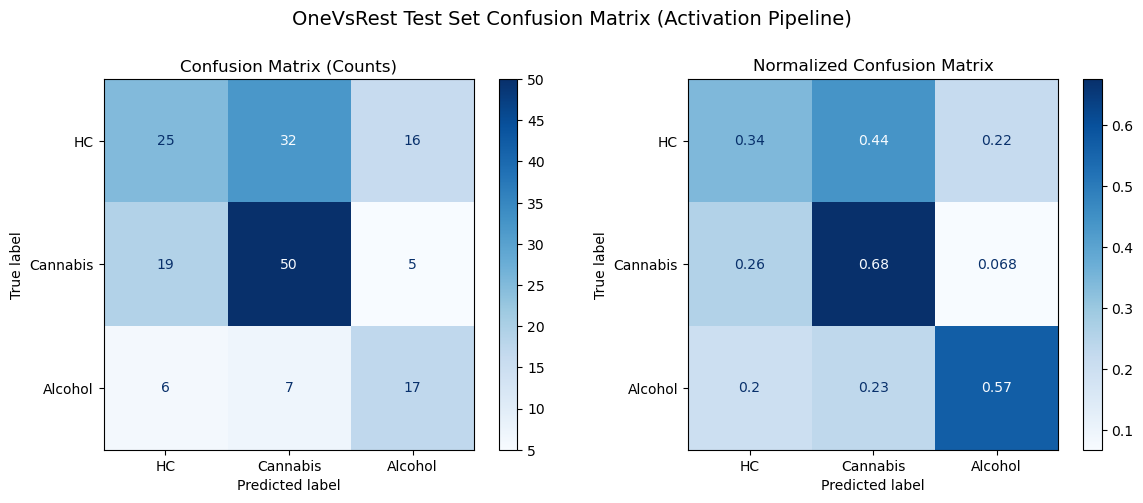


Finished 3-Way Evaluation (OneVsRest - with Pipeline)



In [57]:
# === 16. 3-Way Classification: Evaluation (OneVsRest Strategy - with Pipeline) ===

print("\n" + "="*40)
print("Starting 3-Way Activation Classification - Evaluation (OneVsRest - with Pipeline)")
print("="*40 + "\n")

# Ensure MultiClassEvaluator can handle Pipeline objects
# Need to re-check the implementation or potentially adapt it if it expects only base estimators.
# Assuming MultiClassEvaluator can take a dict of fitted pipelines:

# --- Define the Final OVR PIPELINE with Best Params ---
print(f"\nDefining final OVR pipeline with best SGD params: {best_params_ovr_sgd_cleaned}")
final_base_sgd_ovr = SGDClassifier(
    **best_params_ovr_sgd_cleaned, # Use cleaned best SGD params
    random_state=RANDOM_STATE_MULTICLASS,
    max_iter=MAX_ITER_TRAINING,
    class_weight='balanced'
)
final_ovr_clf = OneVsRestClassifier(final_base_sgd_ovr, n_jobs=-1)
# Create the final pipeline object
final_ovr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', final_ovr_clf)
])

# --- Run MultiClassEvaluator ---
# Pass the *final pipeline object* within a dictionary
multi_evaluator_ovr = MultiClassEvaluator({'OVR_Pipeline_Best': final_ovr_pipeline})

print("\nRunning Multi-Class Evaluation Pipeline (OVR)...")
# Pass UNSCALED data, as scaling is done inside the pipeline during CV
cv_results_ovr, fitted_ovr_pipelines_dict = multi_evaluator_ovr.evaluate_cv(
    X_train=three_X_train, # Pass unscaled train data
    y_train=three_y_train,
    n_splits=CLASSIFICATION_CV_FOLDS,
    random_state_kfold=RANDOM_STATE_KFOlD
)

# --- Display CV Metrics ---
ovr_cv_metrics_df = multi_evaluator_ovr.get_cv_metrics_summary()
print("\nOVR Cross-Validation Metrics Summary (Pipeline):")
display(ovr_cv_metrics_df)

# --- Save Final Model (The Fitted Pipeline Dictionary) ---
multi_evaluator_ovr.save_models(THREECLASS_ONEVREST_PKL) # Saves the dict {'OVR_Pipeline_Best': fitted_pipeline}

# --- Evaluate on Hold-Out Test Set using Saved Pipeline ---
print("\n--- 3-Way Hold-Out Test Set Evaluation (OVR Pipeline) ---")
try:
    # Load the saved dictionary (should contain the fitted pipeline)
    loaded_ovr_pipelines = load_pickle(THREECLASS_ONEVREST_PKL)
    fitted_ovr_pipeline = loaded_ovr_pipelines.get('OVR_Pipeline_Best') # Get the specific pipeline

    if fitted_ovr_pipeline and isinstance(fitted_ovr_pipeline, Pipeline) and three_X_test.size > 0:
        # Predict on the UNSCALED 3-way test data using the loaded pipeline
        preds_test_ovr = fitted_ovr_pipeline.predict(three_X_test)
        test_acc_ovr = accuracy_score(three_y_test, preds_test_ovr)
        print(f"\nTest Accuracy (OVR Pipeline): {test_acc_ovr:.4f}")

        # Display classification report
        print("\nTest Classification Report (OVR Pipeline):")
        target_names = MULTICLASS_LABELS
        print(classification_report(three_y_test, preds_test_ovr, target_names=target_names, zero_division=0))

        # Plot Confusion Matrix
        print("\nPlotting Test Confusion Matrix (OVR Pipeline)...")
        fig_cm_ovr, ax_cm_ovr = plt.subplots(1, 2, figsize=(12, 5))
        ConfusionMatrixDisplay.from_predictions(
            three_y_test, preds_test_ovr, ax=ax_cm_ovr[0],
            display_labels=target_names, cmap=plt.cm.Blues
        )
        ax_cm_ovr[0].set_title('Confusion Matrix (Counts)')
        ConfusionMatrixDisplay.from_predictions(
            three_y_test, preds_test_ovr, ax=ax_cm_ovr[1],
            display_labels=target_names, cmap=plt.cm.Blues, normalize='true'
        )
        ax_cm_ovr[1].set_title('Normalized Confusion Matrix')
        fig_cm_ovr.suptitle('OneVsRest Test Set Confusion Matrix (Activation Pipeline)', fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        fig_cm_ovr.savefig(MULTICLASS_OVR_CM_FIG, format='svg', dpi=1200, bbox_inches='tight')
        print(f"Saved OVR Confusion Matrix plot to {MULTICLASS_OVR_CM_FIG}")
        plt.show()

    elif not fitted_ovr_pipeline: print("Final OVR pipeline could not be loaded or was not fitted.")
    else: print("Test data is empty. Cannot evaluate on test set.")

except FileNotFoundError: logging.error(f"Could not load saved pipeline from {THREECLASS_ONEVREST_PKL}. File not found.")
except Exception as e: logging.error(f"An error occurred loading or evaluating OVR pipeline: {e}", exc_info=True)


print("\n" + "="*40)
print("Finished 3-Way Evaluation (OneVsRest - with Pipeline)")
print("="*40 + "\n")